<a href="https://colab.research.google.com/github/frantu08/Deep_Neural_Networks_Unit_2021/blob/main/2363E_DNN_Assign_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

### Ferenc Huszár, Nic Lane and Neil Lawrence

### 23rd February 2021

Welcome to the second assignment for the Deep Neural Networks module. In this assignment you will explore some of the model architectures we talked about in the second half of lectures.

There are 230 marks given in total for this second assessment ($\approx 70\%$ of the total of 330 marks for this course), broken into three groups:
* (A) 75 marks for the guided questions on Residual Networks
* (B) 75 marks for the guided questions on RNNs
* (C) 80 marks for a mini-project of your choice

You can choose whichever mini-project you want to attempt, we give you a range of options. If you would like to do more of these, that's fine, but will only mark one, whichever appears fist in your submitted notebook. These tasks are a bit more exploratoy, you don't have to go overboard on them. Equally, if you struggle to get them to work the way you wanted/expected, please document what you tried and what you learned.

# A: Residual Networks

In these questions we will work with residual networks (ResNets). In order to save time, we won't be training these models ourselves. Pytorch provides pre-*trained* weights for a range of commonly used models in the `torchvision` package, including ResNets of various depth. Most of the pretrained ResNets available are slightly improved versions of those proposed in 'Deep Residual Learning for Image Recognition' by [He et al (2015)](https://arxiv.org/pdf/1512.03385.pdf).

Note: you can request colab to run a GPU by going to Runtime -> Change runtime type. However, since we are only going to work with single images, it is unlikely this will buy you significant speedup.


## Setting up: Blas the border collie

To start, we will look at whether ResNets of different length can correctly classify my friend's dog Blas as a Border Collie.

In [ ]:
!wget https://caballerojose.com/images/blas.jpg -P blas_the_dog/test

--2021-03-19 08:08:01--  https://caballerojose.com/images/blas.jpg
Resolving caballerojose.com (caballerojose.com)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to caballerojose.com (caballerojose.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221678 (216K) [image/jpeg]
Saving to: ‘blas_the_dog/test/blas.jpg’

blas.jpg            100%[===================>] 216.48K  --.-KB/s    in 0.005s  

2021-03-19 08:08:01 (42.8 MB/s) - ‘blas_the_dog/test/blas.jpg’ saved [221678/221678]



### Loading an image

We will use the Python Imaging Library (PIL) to load the image. Colab then displays the image in-line if it is the output of the last line in the cell. Hello Blas!

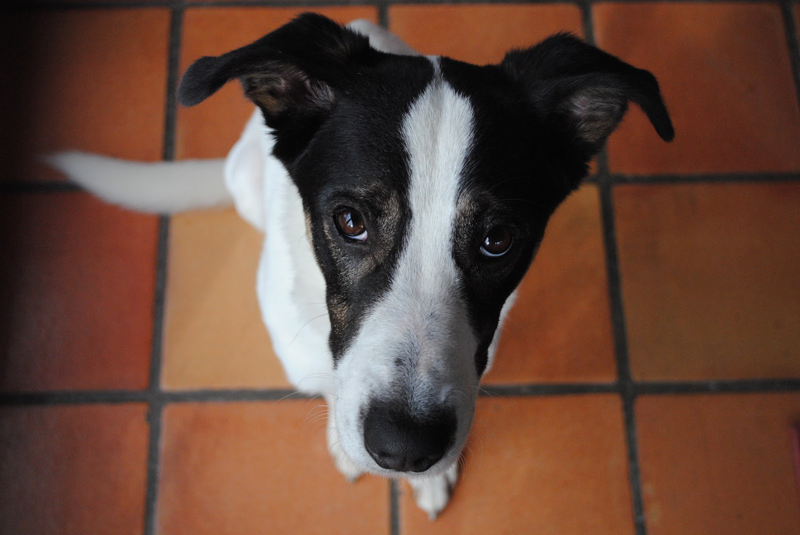

In [ ]:
from PIL import Image
img = Image.open('blas_the_dog/test/blas.jpg')
img.resize((800,535))

### Transformations

ConvNets expect input images to be of a certain size, otherwise the dimensions of the tensors within the network don't work out. We have to resize this image so it is of size $224\times 224$ as the network expects. Secondly, when training neural networks, we often normalise the inputs (substract the mean and divide by the standard deviation). As this model was trained on ImageNet, we have to use the mean and standard deviation from this dataset. Thankfully, we don't have to compute this, as it's included in the [pytorch documentation](https://pytorch.org/vision/0.8/models.html) (as well as elsewhere on the internet).

We will use `transforms` from the `torchvision` module to apply these transformations to the image. We also convert from `PIL.Image` to `torch.Tensor` in the process:


In [ ]:
from torchvision import transforms

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                )])

img_t = transform(img)

We can display the transformed image by converting it back to `PIL.Image`. We can see that the image was downsized, cropped to it's centre square region, and the colours are messed up due to normalization.

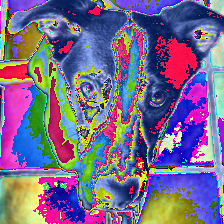

In [ ]:
transforms.ToPILImage()(img_t)

### Loading  the model

Now we are going to load the pre-trained 18-layer ResNet model from the `torchvision` library.

In [ ]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)

Let's see how the model classifies Blas, the border collie. For this, we have to turn the image tensor into a minibatch of 1 example, which practically means adding an extra dimension to the tensor. This can be done using the `unsqueeze` function.

In [ ]:
x = img_t.unsqueeze(0)
y = resnet18(x)
y.size()

torch.Size([1, 1000])

The model's output is a vector of 1000 logits, one for each class in the ImageNet dataset. To interpret this, we have to know what the ImageNet classes are. Also, the logits themselves are less human-readable, so we are going to turn them into probabilities using a `softmax` function. This helper function below will do this for us.

In [ ]:
import requests
import json
from torch.nn.functional import softmax

imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(imagenet_labels_url)
imagenet_class_names = json.loads(response.text)

def top_5_classes(y, class_names = None):
  if class_names==None:
    imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    response = requests.get(imagenet_labels_url)
    class_names = json.loads(response.text)
  p = softmax(y[0,:], dim=0)
  values, indices = p.topk(5)
  return [(class_names[index], value) for index, value in zip(indices.detach().numpy(), values.detach().numpy())]

In [ ]:
top_5_classes(y)

[('bucket', 0.007806162),
 ('plunger', 0.007172808),
 ('hook', 0.0070160483),
 ('waste container', 0.00548113),
 ('water bottle', 0.0054325894)]

Oops, the model doesn't seem to recognise Blas. It thinks Blas is a bucket, plunger or hook. This is because in order to use the pretrained models in pytorch, we have to set them to evaluation mode. When training deep neural networks, sometimes the networks work differently at training and test time. For example, when using a technique called dropout, random units in the network may be dropped at training time, but at test time, all units are used and their output is scaled. Similarly, when using batch normalisation, the network works differently in training time and at test time. To set models to evaluation mode we can use the `eval` function.

In [ ]:
resnet18.eval()
y = resnet18(x)
top_5_classes(y)

[('Staffordshire Bull Terrier', 0.18194425),
 ('Cardigan Welsh Corgi', 0.14102171),
 ('American Staffordshire Terrier', 0.12816133),
 ('Basenji', 0.09343243),
 ('Whippet', 0.09127136)]

OK, getting there. At least the model now recognises Blas as a dog, but misses the specific breed. The correct class would be a Border Collie.

## Question A.1: Trying different pretrained networks

Now try different models from `torchvision` and see which ones can classify Blas correctly. In particular, check out deeper versions of ResNets. Use the [documentation](https://pytorch.org/vision/0.8/models.html) to find out what other networks are available. Use the code blocks below, and the text field to summarise what you found. (For full marks, try multiple ResNets, and at least two different non-ResNets).

*10 marks*

### Answer A.1

Please use this cell to summarise which networks you tried.

In [ ]:
# please add code for question A.1 here. You may add further code cells below.

from torchvision import models

In descending order based on top 5 error in the documentation, I try out below the following ResNets on Pytorch:
- ResNet-34
- ResNet-50
- ResNet-101
- ResNet-152
- Wide ResNet-50-2
- Wide ResNet-101-2

After that I will go on and try the following non-ResNets:
- Densenet-161
- MNASNet 1.0
- MobileNet
- Inceptionv3


#### *ResNet-34*
We can see below that already the next architecture after resnet 18 identifies Blas' race correctly as the 1st choice and assignes it a significantly larger probability than the other guesses.

In [ ]:
resnet34 = models.resnet34(pretrained=True)
resnet34.eval()
y = resnet34(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


[('Border Collie', 0.3744087),
 ('Australian Kelpie', 0.10416237),
 ('Basenji', 0.093319185),
 ('Whippet', 0.063869014),
 ('collie', 0.060557857)]

#### *ResNet-50*
We can see below that this ResNet also makes the correct 1st guess, however, with lower certainty than the ResNet-34. But, the advantage this one has is that the 2nd guess is the general "collie" so the network probably makes a connection (and by that I mean it recognises the similaritites) between a general breed and its members (dogs of collie type). Compared to this, the ResNet-34 only guesses collie as the 5th possibility, not so close to the specific race. However, I am not sure if this is a valid intuition as I am sadly not an expert of dog breeds.

In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()
y = resnet50(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


[('Border Collie', 0.26453617),
 ('collie', 0.18160026),
 ('Cardigan Welsh Corgi', 0.17722456),
 ('Whippet', 0.12113578),
 ('Australian Kelpie', 0.05963931)]

#### *ResNet-101*
This one behaves similarly to the ResNet-34, assigning a high probability to Border Collie and a low one to collie. In comparison to ResNet-34 however, the probability of the 2nd guess is not that much lower than the rest.

In [ ]:
resnet101 = models.resnet101(pretrained=True)
resnet101.eval()
y = resnet101(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


[('Border Collie', 0.33726576),
 ('Basenji', 0.23494701),
 ('Cardigan Welsh Corgi', 0.17642708),
 ('collie', 0.06710181),
 ('Boston Terrier', 0.027117426)]

#### *ResNet-152*

Going even deeper, this resnet has high confidence in Border Collie and then, also high in collie, while the other top 5 guesses have a lower probability. I would guess this indicates good generalization.


In [ ]:
resnet152 = models.resnet152(pretrained=True)
resnet152.eval()
y = resnet152(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


[('Border Collie', 0.36757603),
 ('collie', 0.29964197),
 ('Whippet', 0.1255131),
 ('Cardigan Welsh Corgi', 0.07364116),
 ('Australian Kelpie', 0.033829622)]

#### *Wide ResNet-50-2*

This architecture has the most confidence so far in its first guess.


In [ ]:
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
wide_resnet50_2.eval()
y = wide_resnet50_2(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


[('Border Collie', 0.40921822),
 ('Cardigan Welsh Corgi', 0.1260889),
 ('Whippet', 0.11586778),
 ('collie', 0.090853944),
 ('Australian Kelpie', 0.061433244)]

#### *Wide ResNet-101-2*
This has similar confidence in the correct guess, as the rest.

In [ ]:
wide_resnet101_2 = models.wide_resnet101_2(pretrained=True)
wide_resnet101_2.eval()
y = wide_resnet101_2(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


[('Border Collie', 0.3624439),
 ('Whippet', 0.2292052),
 ('collie', 0.117414854),
 ('Cardigan Welsh Corgi', 0.09347275),
 ('Australian Kelpie', 0.043870665)]

#### *Densenet-161* 
The Desnet has the correct first guess, but extremely close in confidence to the wrong answer.

In [ ]:
densenet161 = models.densenet161(pretrained=True)
densenet161.eval()
y = densenet161(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


[('Border Collie', 0.265248),
 ('Basenji', 0.25631872),
 ('Cardigan Welsh Corgi', 0.1058264),
 ('collie', 0.09231523),
 ('Australian Kelpie', 0.069339864)]

#### *MNASNet 1.0*
The MNASNet has low confidence in Border Collie, as it is the 4th option, with 0.1 compared to the first choice of a Whipped (32). Of all the first wrong choices this is a funny one as a Whippet, doesn't look that much like a border collie, while the Cardigan Welsh Corgi (the wrong first choice in the architectures below) does share some facial similarity with a Border Collie.

In [ ]:
mnasnet = models.mnasnet1_0(pretrained=True)
mnasnet.eval()
y = mnasnet(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1.0_top1_73.512-f206786ef8.pth


[('Whippet', 0.32150066),
 ('Cardigan Welsh Corgi', 0.27941412),
 ('Basenji', 0.11414804),
 ('Border Collie', 0.10689451),
 ('Australian Kelpie', 0.06648736)]

#### *MobileNet V2*

Very small probability given to Border Collie in comparison to the 1st choice.

In [ ]:
mobilenet = models.mobilenet_v2(pretrained=True) # 53 layers
mobilenet.eval()
y = mobilenet(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


[('Cardigan Welsh Corgi', 0.42300555),
 ('Whippet', 0.24346109),
 ('Basenji', 0.1304674),
 ('Border Collie', 0.07098343),
 ('Italian Greyhound', 0.03070452)]

#### *Inception v3* 
48 layers deep

This network is very confident in its first choice, which is the wrong one. Border Collie and collie are part of the top-5 guesses but with very low probability. This maybe indicates poor generalization.

In [ ]:
inceptionv3 = models.inception_v3(pretrained=True)
inceptionv3.eval()
y = inceptionv3(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


[('Cardigan Welsh Corgi', 0.97994256),
 ('Basenji', 0.01792802),
 ('toy terrier', 0.00077250425),
 ('Border Collie', 0.0007285499),
 ('collie', 0.00049352885)]

#### *ResNeXt*
From the pytorch models this one had the best top-5 and top-1 errors, but doesn't seem to produce the correct first guess, and it also gives "border collie" a very low probability. It has an extremely high confidence in its first choice. Again, this maybe indicates poor generalization.

The ResNeXt implemented a paradigm from the Inception model (split-transform-merge), which might explain the similar results.

In [ ]:
resnex101_32x8d = models.resnext101_32x8d(pretrained=True)
resnex101_32x8d.eval()
y = resnex101_32x8d(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


[('Cardigan Welsh Corgi', 0.9398499),
 ('Border Collie', 0.020422004),
 ('Whippet', 0.0121265175),
 ('Basenji', 0.006576934),
 ('collie', 0.0045894827)]

## Inspecting and modifying networks

For the next question, you will need to modify the pre-trained networks, and you will need to look inside them. Below, we share a few things that will help you learn how models work. First, let's look at what the `resnet18` architecture looks like and how that architecture is represented in pytorch. You can print the model to see a text description of it:

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Here, modules are listed from top to bottom in order of how they are executed.In a pytorch ResNet, residual blocks are organised into `layers`, each of which contain sequences of residual blocks. You will notice that:
* the number of channels keeps doubling at each layer, in this case from 128 -> 256 -> 512.
* at the same time, the figure size is halved with each layer. The image size is halved by `MaxPool2d` layers as well as strided convolutions where the stride is `2`.
* a `resnet18` is built out of `BasicBlock` building blocks, which are the simple residual block proposed by [He et al, (2015)](https://arxiv.org/abs/1512.03385) which I showed in the lecture. Deeper ResNets, such as `resnet50` use a more complicated `Bottleneck` component instead.
* in pytorch, the linear and nonlinear parts of a layer are separate, i.e. the convolution and subsequent ReLU activation are handled as separate layers.

To access the second convolution layer from the second residual block at the third layer, you can write the following:

In [ ]:
resnet18.layer3[1].conv2

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

And you can access parameters of layers like so.

In [ ]:
resnet18.conv1.weight.size()

torch.Size([64, 3, 7, 7])

We can visualise the convolution kernels on the first layer using the code below. In addition to showing how to access weights, you may find some of this code useful as an example of using the `matplotlib.pylab` package for plotting.

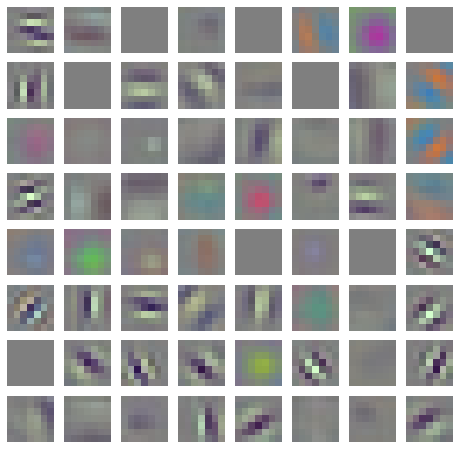

In [ ]:
import numpy as np
from matplotlib import pylab as plt

f = plt.figure(figsize = (8,8))

weights = resnet18.conv1.weight.detach().numpy()
#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
weights = weights/(np.abs(weights).max())/2+0.5

#there are 64 convolution kernels, which we will arrange along an 8x8 grid
for i, w in enumerate(weights):
  plt.subplot(8, 8, i+1)
  # we move the colour channel axis to the end, this is where imshow expects it
  plt.imshow(np.moveaxis(w, 0, -1));
  plt.axis('off')

In pytorch, you can inspect what each layer of the network does by using forward hooks. A forward hook is a python function that gets called whenever the layer is evaluated (i.e. data is passed through the layer). The forward hook function receives both the input and the output of the module. In pytorch, you can add a forward hook using the register_forward_hook function. 

For example, in the code below, I attach a hook to a layer, which simply prints something out. Instead of attaching the hook to the resnet18, I first create a `deepcopy` of the model, so the hook gets attached to the copy, but not to the `resnet18` model which I may use later.

In [ ]:
import copy

def useless_hook(module, input, output):
  print('The hook was called.')

model = copy.deepcopy(resnet18)
model.layer3[1].conv2.register_forward_hook(useless_hook)
y = model(x)
y = model(x)

The hook was called.
The hook was called.


## Question A.2: Inspecting layers in neural networks

This question has a subtasks:
1. print the number of parameters in each of the operations/layers of the `ResNet18`, and count how many there are in total.
1. print the *shape of the output tensor* of the second convolution operation (`conv2`) within every single residual block in a `ResNet18`. *Tip:* you can use a forward hook.
1. Extract the activation (output) of a layer of your choice within the ResNet18, and visualise the activations using `matplotlib.pylab.imshow`. *Tip:* you can use a forward for this here, too.
1. Visualise the convolution weights (also called kernels) in the first convolution layer of a pretrained AlexNet and a VGG19 network. Compare it to what we obtained the ResNet above. Document the similarities and differences do you notice.


*Tips:*
* you can use `copy.deepcopy` to create copies of models.
* You can use `tensor.size()` to get the sape.
* you have to use `tensor.detach().numpy()` to detach a pytorch tensor from the computational graph and convert it to a numpy array.
* for plotting, you can use the `matplotlib.pylab` module. The function `imshow` can be usedd to plot activation maps as images, `axis('off')` is handy for removing axis labels. `subplot` allows you to create grids of multiple images in one figure, finally `figure(figsize=(x, y))` lets you change the overall size of the figure.
* on a pytorch module you can call `named_children` and `name_parameters` to iterate over layers and parameters, respectively.

*15 marks*

### Answer A.2

please provide your answers in code cells below (you may use multiple code cells).

**A2.1** *Print the number of parameters in each of the operations/layers of the ResNet18, and count how many there are in total.*

**Intuition:**

I am unsure if the questions wants the total count of parameters or just the count of named parameters, so I will calculate both, as they can be easily obtained from a double loop over name_children and name_parameteres. 
Each named parameter has a size and each of the scalars inside it represent a parameter of the model, so the total number of parameteres of a named_parameter is the number of scalars inside it, which can be obtained by multiplying out the integers that represent the shape. E.g: for named_parameter of shape [4,4,1,1], the number of parameters inside it would be 16.
In order to check the calculations for the total number of parameters are correct, I then also call model-summary used in the 1st assignment. 
We can see below that both methods give a total number of parameters of 11,689,512. The values at individual layers match as well.


In [ ]:
# tip: on a pytorch module you can call `named_children` and `name_parameters` to iterate over layers and parameters, respectively.
import numpy as np

named_paramas_count = 0
total_count = 0
for name, module in resnet18.named_children():
  print(name, " :")
  for name, param in module.named_parameters():
    named_paramas_count = named_paramas_count + 1
    param_list = param.shape
    print("    ", name, " has params size:", param.size(), " and total: ",  np.prod(param_list), "parameters")
    total_count = total_count + np.prod(param_list)

print("Total count: ", total_count)
print("Named parameters count: ", named_paramas_count)

conv1  :
     weight  has params size: torch.Size([64, 3, 7, 7])  and total:  9408 parameters
bn1  :
     weight  has params size: torch.Size([64])  and total:  64 parameters
     bias  has params size: torch.Size([64])  and total:  64 parameters
relu  :
maxpool  :
layer1  :
     0.conv1.weight  has params size: torch.Size([64, 64, 3, 3])  and total:  36864 parameters
     0.bn1.weight  has params size: torch.Size([64])  and total:  64 parameters
     0.bn1.bias  has params size: torch.Size([64])  and total:  64 parameters
     0.conv2.weight  has params size: torch.Size([64, 64, 3, 3])  and total:  36864 parameters
     0.bn2.weight  has params size: torch.Size([64])  and total:  64 parameters
     0.bn2.bias  has params size: torch.Size([64])  and total:  64 parameters
     1.conv1.weight  has params size: torch.Size([64, 64, 3, 3])  and total:  36864 parameters
     1.bn1.weight  has params size: torch.Size([64])  and total:  64 parameters
     1.bn1.bias  has params size: torch.Siz

In [ ]:
%pip install pytorch-model-summary

In [ ]:
from pytorch_model_summary import summary

summary(resnet18, x, show_input=True, print_summary=True, show_parent_layers= True, show_hierarchical=True)

----------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)           Input Shape         Param #     Tr. Param #
          ResNet                Conv2d-1      [1, 3, 224, 224]           9,408           9,408
          ResNet           BatchNorm2d-2     [1, 64, 112, 112]             128             128
          ResNet                  ReLU-3     [1, 64, 112, 112]               0               0
          ResNet             MaxPool2d-4     [1, 64, 112, 112]               0               0
          ResNet            BasicBlock-5       [1, 64, 56, 56]          73,984          73,984
          ResNet            BasicBlock-6       [1, 64, 56, 56]          73,984          73,984
          ResNet            BasicBlock-7       [1, 64, 56, 56]         230,144         230,144
          ResNet            BasicBlock-8      [1, 128, 28, 28]         295,424         295,424
          ResNet            BasicBlock-9      [1, 

'----------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)           Input Shape         Param #     Tr. Param #\n==============================================================================================\n          ResNet                Conv2d-1      [1, 3, 224, 224]           9,408           9,408\n          ResNet           BatchNorm2d-2     [1, 64, 112, 112]             128             128\n          ResNet                  ReLU-3     [1, 64, 112, 112]               0               0\n          ResNet             MaxPool2d-4     [1, 64, 112, 112]               0               0\n          ResNet            BasicBlock-5       [1, 64, 56, 56]          73,984          73,984\n          ResNet            BasicBlock-6       [1, 64, 56, 56]          73,984          73,984\n          ResNet            BasicBlock-7       [1, 64, 56, 56]         230,144         230,144\n          ResNet            BasicBlock-

**A2.2** *Print the **shape of the output tensor** of the second convolution operation (`conv2`) within every single residual block in a `ResNet18`. ***Tip:*** you can use a forward hook.*

In [ ]:
import copy

def my_hook(module, input, output):
  print(output.size())

model = copy.deepcopy(resnet18)
model.layer1[0].conv2.register_forward_hook(my_hook)
model.layer1[1].conv2.register_forward_hook(my_hook)
model.layer2[0].conv2.register_forward_hook(my_hook)
model.layer2[1].conv2.register_forward_hook(my_hook)
model.layer3[0].conv2.register_forward_hook(my_hook)
model.layer3[1].conv2.register_forward_hook(my_hook)
model.layer4[0].conv2.register_forward_hook(my_hook)
model.layer4[1].conv2.register_forward_hook(my_hook)


y = model(x)

torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])
torch.Size([1, 128, 28, 28])
torch.Size([1, 128, 28, 28])
torch.Size([1, 256, 14, 14])
torch.Size([1, 256, 14, 14])
torch.Size([1, 512, 7, 7])
torch.Size([1, 512, 7, 7])


**A2.3** *Extract the activation (output) of a layer of your choice within the ResNet18, and visualise the activations using `matplotlib.pylab.imshow`. **Tip:** you can use a forward for this here, too*.



**Approach**: I will look at the output of all 4 layers below so I can use them as comparison points for the next subquestion. The last nn in each layer is bn2 so I'm plotting the weights of that.

torch.Size([64])
(1, 64, 56, 56)


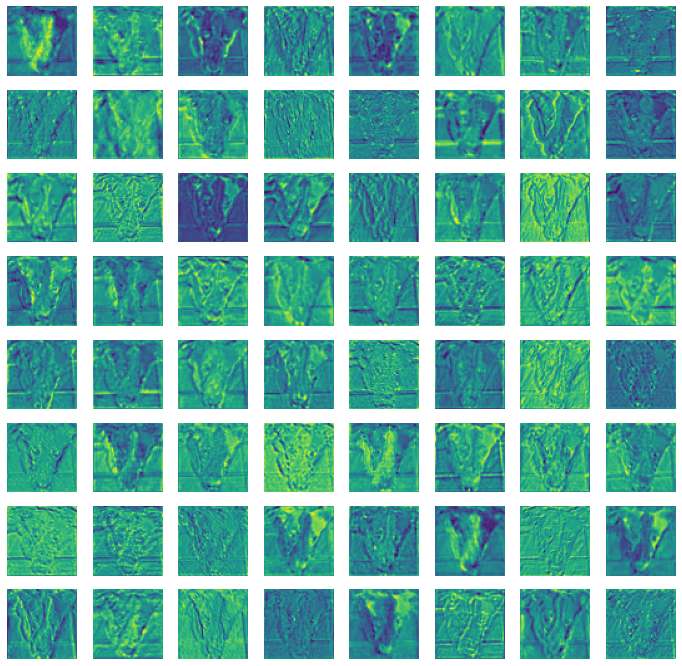

In [ ]:
import numpy as np
from matplotlib import pylab as plt

model = copy.deepcopy(resnet18)

print(resnet18.layer1[1].bn2.weight.size())

def my_hook(module, input, output):
  weights = output.detach().numpy()
  # normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
  weights = weights/(np.abs(weights).max())/2+0.5
  
  f = plt.figure(figsize = (12,12))

  print(weights.shape)
  # weights.shape is (1, 64, 56, 56) so it has 64 channels. I'll print each channel as a 56*56 image

  for i, w in enumerate(weights[0]): #  going over the 64 channels
    plt.subplot(8, 8, i+1)
    # we move the colour channel axis to the end, this is where imshow expects it
    # print(w.shape)
    plt.imshow(w); # print image of 56*56 pixels, no more need for moving axes
    # plt.imshow(np.moveaxis(w, 0, -1)); 
    plt.axis('off')

model.layer1[1].bn2.register_forward_hook(my_hook)

y = model(x)

torch.Size([64])
(1, 64, 56, 56)


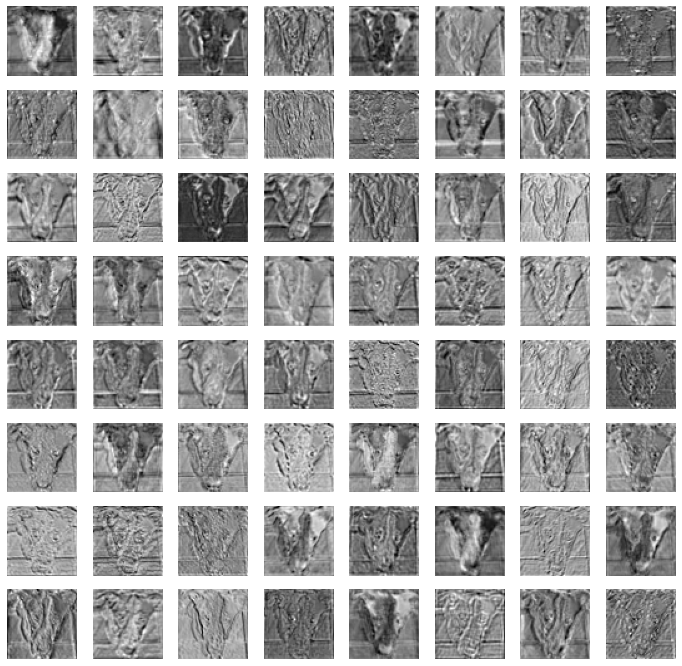

In [ ]:
# same as above but with cmap to gray to see the effect better
import numpy as np
from matplotlib import pylab as plt

model = copy.deepcopy(resnet18)

# I am choosing the output of layer 1
print(resnet18.layer1[1].bn2.weight.size())

def my_hook(module, input, output):
  weights = output.detach().numpy()
  # normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
  weights = weights/(np.abs(weights).max())/2+0.5
  
  f = plt.figure(figsize = (12,12))

  print(weights.shape)
  # weights.shape is (1, 64, 56, 56) so it has 64 channels. I'll print each channel as a 56*56 image

  for i, w in enumerate(weights[0]): #  going over the 64 channels
    plt.subplot(8, 8, i+1)
    # we move the colour channel axis to the end, this is where imshow expects it
    # print(w.shape)
    plt.imshow(w, cmap = "gray"); # print image of 56*56 pixels, no more need for moving axes
    # plt.imshow(np.moveaxis(w, 0, -1)); 
    plt.axis('off')

model.layer1[1].bn2.register_forward_hook(my_hook)

y = model(x)

torch.Size([128])
(1, 128, 28, 28)


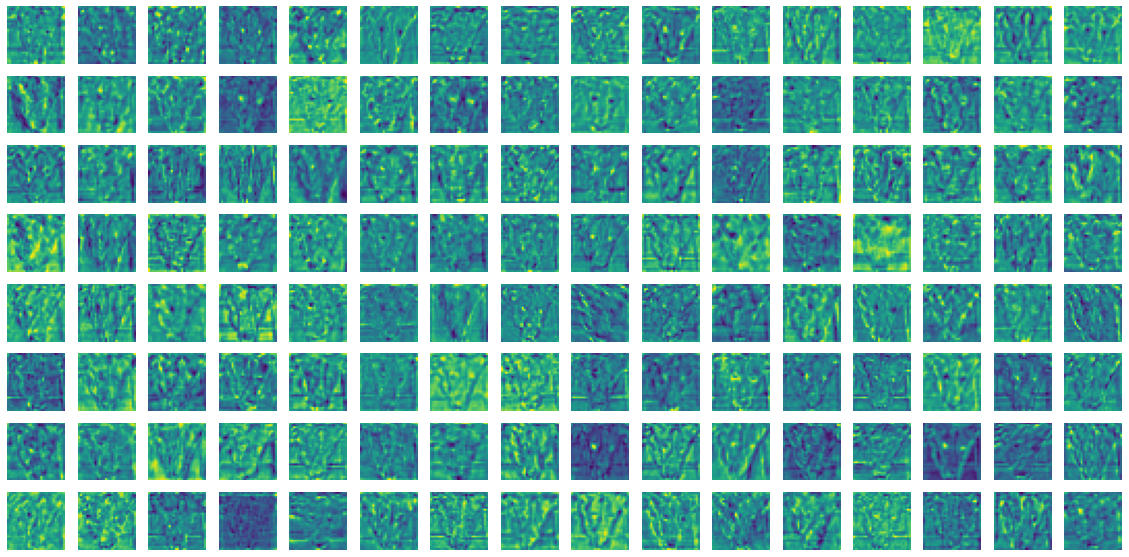

In [ ]:
import numpy as np
from matplotlib import pylab as plt

model = copy.deepcopy(resnet18)

# I am choosing the output of layer 1
print(resnet18.layer2[1].bn2.weight.size())

def my_hook(module, input, output):
  weights = output.detach().numpy()
  # normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
  weights = weights/(np.abs(weights).max())/2+0.5
  
  f = plt.figure(figsize = (20, 10))

  print(weights.shape)
  # weights.shape is (1, 128, 28, 28) so it has 128 channels. I'll print each channel as a 28*28 image

  for i, w in enumerate(weights[0]):
    plt.subplot(8, 16, i+1)
    # we move the colour channel axis to the end, this is where imshow expects it
    plt.imshow(w); 
    plt.axis('off')

model.layer2[1].bn2.register_forward_hook(my_hook)

y = model(x)

torch.Size([128])
(1, 128, 28, 28)


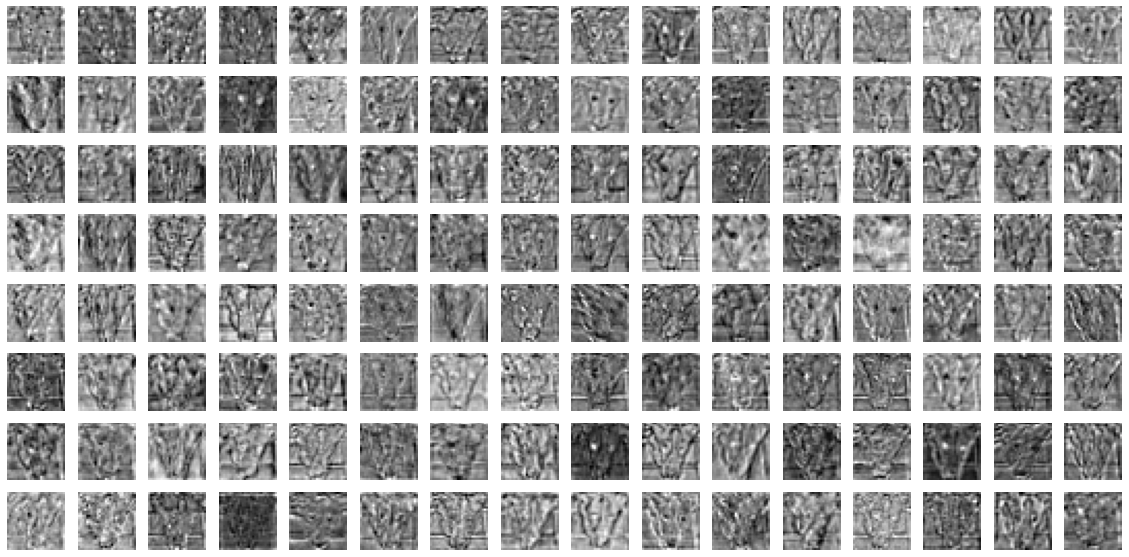

In [ ]:
import numpy as np
from matplotlib import pylab as plt

model = copy.deepcopy(resnet18)

# I am choosing the output of layer 1
print(resnet18.layer2[1].bn2.weight.size())

def my_hook(module, input, output):
  weights = output.detach().numpy()
  # normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
  weights = weights/(np.abs(weights).max())/2+0.5
  
  f = plt.figure(figsize = (20, 10))

  print(weights.shape)
  # weights.shape is (1, 128, 28, 28) so it has 128 channels. I'll print each channel as a 28*28 image

  for i, w in enumerate(weights[0]):
    plt.subplot(8, 16, i+1)
    # we move the colour channel axis to the end, this is where imshow expects it
    plt.imshow(w, cmap = "gray"); 
    plt.axis('off')

model.layer2[1].bn2.register_forward_hook(my_hook)

y = model(x)

torch.Size([256])
(1, 256, 14, 14)


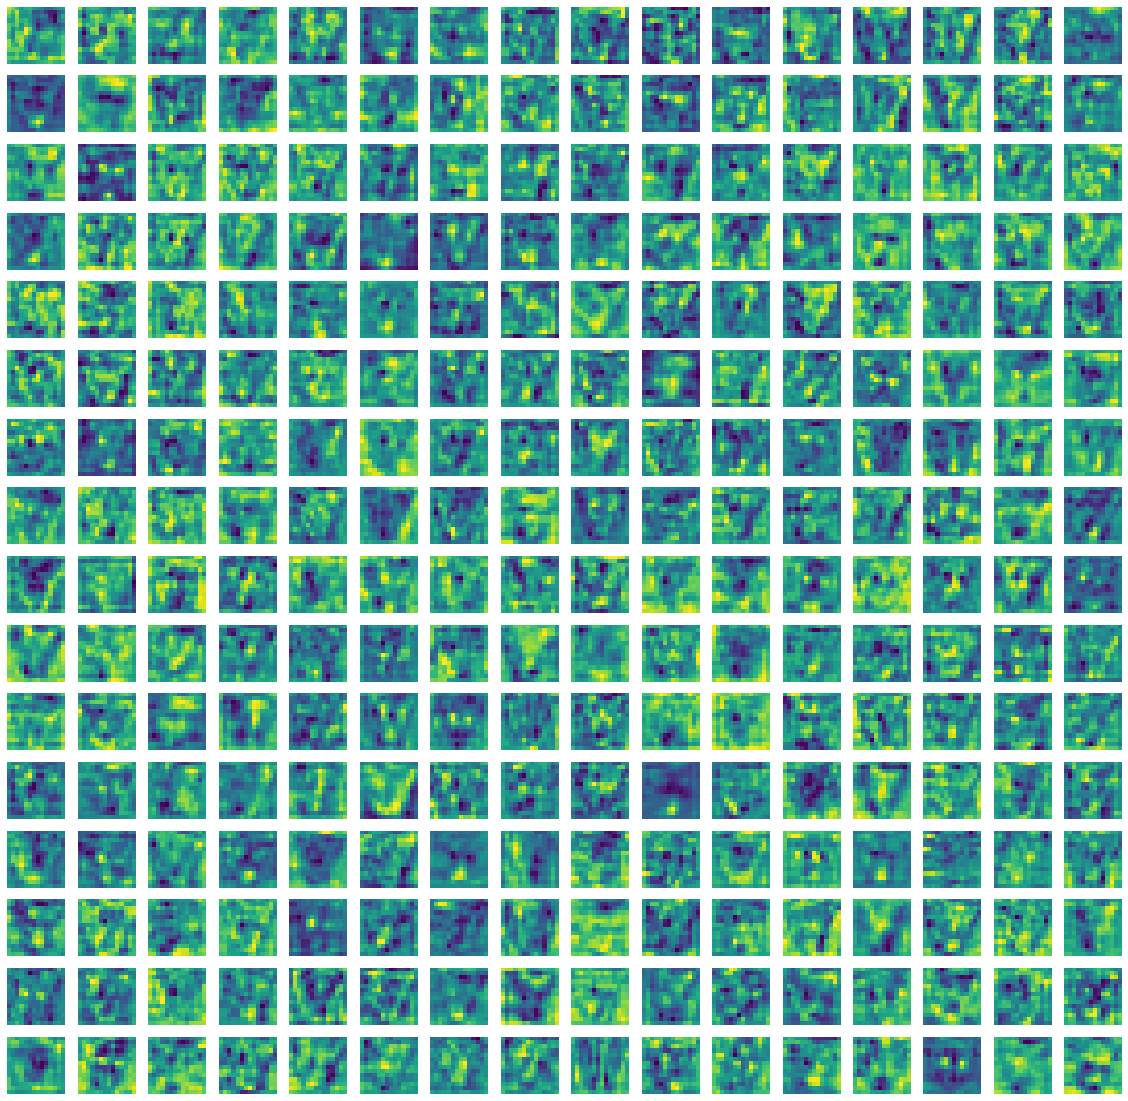

In [ ]:
import numpy as np
from matplotlib import pylab as plt

model = copy.deepcopy(resnet18)

# I am choosing the output of layer 1
print(resnet18.layer3[1].bn2.weight.size())

def my_hook(module, input, output):
  weights = output.detach().numpy()
  # normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
  weights = weights/(np.abs(weights).max())/2+0.5
  
  f = plt.figure(figsize = (20, 20))

  print(weights.shape)
  # weights.shape is (1, 256, 56, 56) so it has 256 channels. I'll print each channel as a 14*14 image

  for i, w in enumerate(weights[0]):
    plt.subplot(16, 16, i+1)
    # we move the colour channel axis to the end, this is where imshow expects it
    plt.imshow(w); 
    plt.axis('off')

model.layer3[1].bn2.register_forward_hook(my_hook)

y = model(x)

torch.Size([512])
(1, 512, 7, 7)


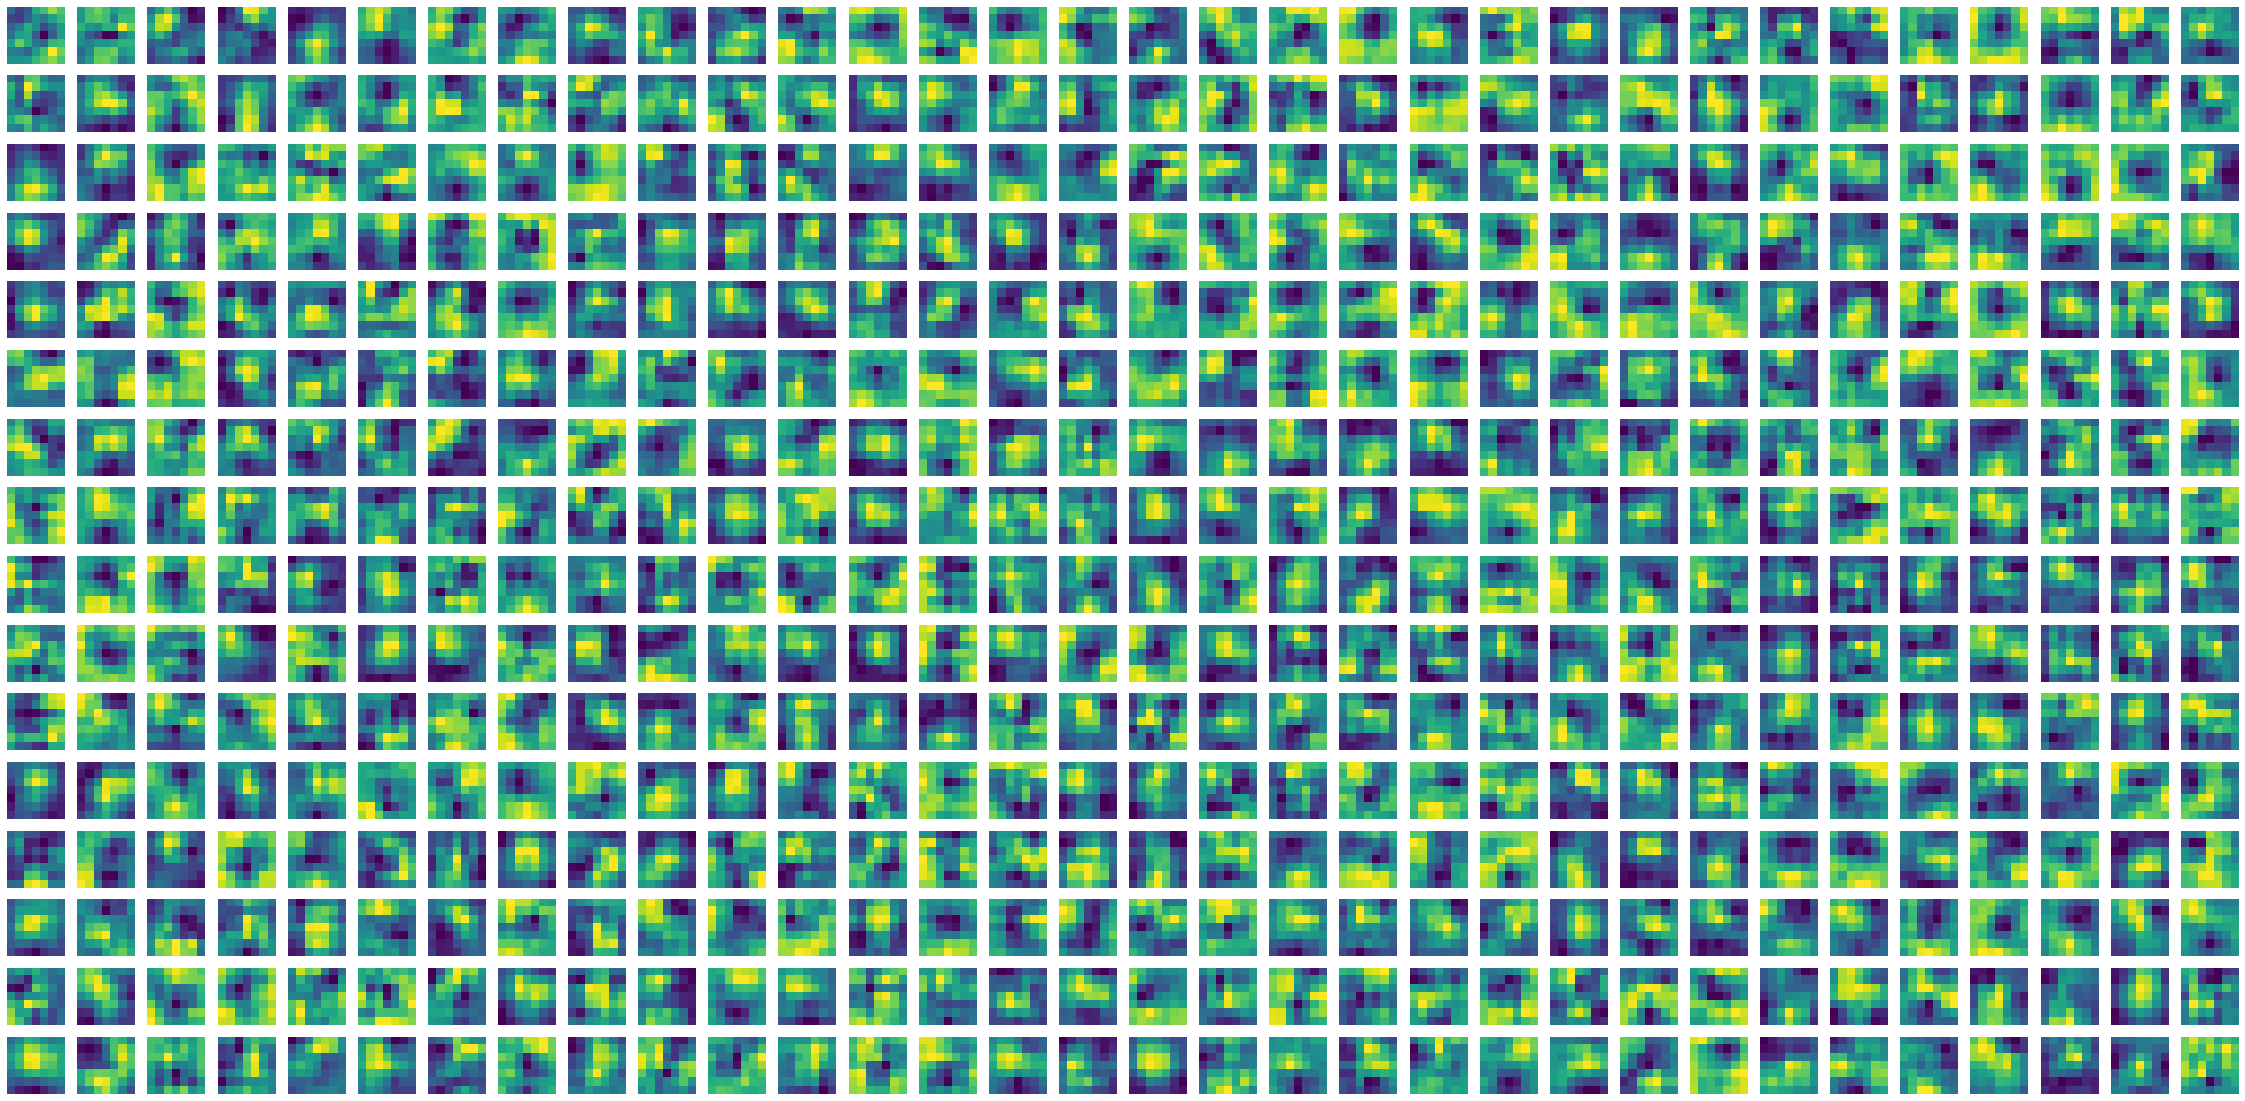

In [ ]:
import numpy as np
from matplotlib import pylab as plt

model = copy.deepcopy(resnet18)

print(resnet18.layer4[1].bn2.weight.size())

def my_hook(module, input, output):
  weights = output.detach().numpy()
  # normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
  weights = weights/(np.abs(weights).max())/2+0.5
  
  f = plt.figure(figsize = (40, 20))

  print(weights.shape)
  # weights.shape is (1, 512, 7, 7) so it has 512 channels. I'll print each channel as a 7*7 image

  for i, w in enumerate(weights[0]):
    plt.subplot(16, 32, i+1)
    # we move the colour channel axis to the end, this is where imshow expects it
    plt.imshow(w); 
    plt.axis('off')

model.layer4[1].bn2.register_forward_hook(my_hook)

y = model(x)

**A2.4.1** *Visualise the convolution weights (also called kernels) in the first convolution layer of a pretrained AlexNet and a VGG19 network.*


*Tips:*
* you can use `copy.deepcopy` to create copies of models.
* You can use `tensor.size()` to get the sape.
* you have to use `tensor.detach().numpy()` to detach a pytorch tensor from the computational graph and convert it to a numpy array.
* for plotting, you can use the `matplotlib.pylab` module. The function `imshow` can be usedd to plot activation maps as images, `axis('off')` is handy for removing axis labels. `subplot` allows you to create grids of multiple images in one figure, finally `figure(figsize=(x, y))` lets you change the overall size of the figure.
* on a pytorch module you can call `named_children` and `name_parameters` to iterate over layers and parameters, respectively.

*15 marks*

In [ ]:
alexnet = models.alexnet(pretrained=True)
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


(64, 3, 11, 11)


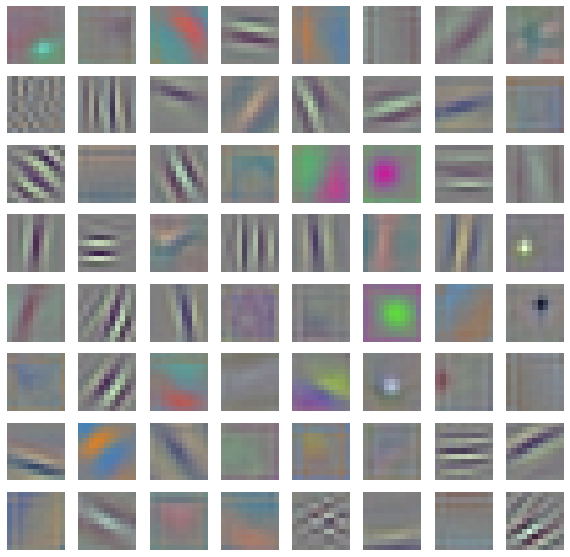

In [ ]:
import numpy as np
from matplotlib import pylab as plt

f = plt.figure(figsize = (10,10))

weights = alexnet.features[0].weight.detach().numpy()
#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
weights = weights/(np.abs(weights).max())/2+0.5

print(weights.shape)

#there are 64 convolution kernels, which we will arrange along an 8x8 grid
for i, w in enumerate(weights):
  plt.subplot(8, 8, i+1)
  # we move the colour channel axis to the end, this is where imshow expects it
  plt.imshow(np.moveaxis(w, 0, -1));
  plt.axis('off')

In [ ]:
vgg19 = models.vgg19(pretrained=True)
print(vgg19)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

(64, 3, 3, 3)


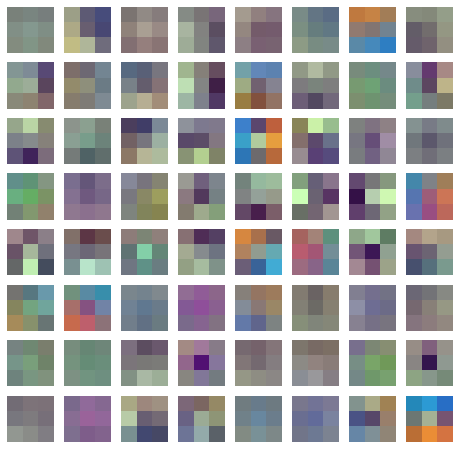

In [ ]:
import numpy as np
from matplotlib import pylab as plt

f = plt.figure(figsize = (8,8))

weights = vgg19.features[0].weight.detach().numpy()
#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
weights = weights/(np.abs(weights).max())/2+0.5

print(weights.shape)

#there are 64 convolution kernels, which we will arrange along an 8x8 grid
for i, w in enumerate(weights):
  plt.subplot(8, 8, i+1)
  # we move the colour channel axis to the end, this is where imshow expects it
  plt.imshow(np.moveaxis(w, 0, -1));
  plt.axis('off')

**A2.4.2** *Compare it to what we obtained the ResNet above. Document the similarities and differences do you notice.*

**Amswer:**
Convolutional kernels (such as the ones we can see in A2.4 in vgg19 and AlexNet) are used for convolution with parts of the image in order to (as per wikipedia) to blurr, sharpen, emboss, or do edge detection (or maybe more). 
Example of classic edge-detection kernels are those for identifying horizontal or vertical lines in an image (the simple binary one for identifying horizontal lines looks itself like just a black image with white stripes that when applied to an image will make the horizontal lines in it stand out). 

In the kernels from AlexNet we can identify such horizontal and vertical lines and quite a lot of oblique ones as well. The kernels from vgg19 are too small to indentify any lines in them. These might be used for something else other than edge detection. 

In both cases (alexnet and vgg) each image represents a kernel.

In contrast in A.3 we look at the output of a layer, and, as described, the number of channels keeps doubling at each layer, (in this case from 128 -> 256 -> 512), while the figure size is halved with each layer. So at the output of each layer we see the all the image channels post-convolution. In the output of the 1st two layers we can clearly see in most channels the shape of the dog, while some images are a bit more blurry. In the 2nd layer we can see that the eyes stand out in some images, and edges from the shape of the dog are still visible. The outputs from the 3rd layer become more blurry and the ones from the last layer are features that can't really be interpreted with the naked eye anymore.

In general if the kernel's intention is visible (such as a kernel with lines), we know that in the output of the convolution we should see the intention (such the lines of the images in the same direction/angle as the ones in the kernel). But this is not the case for all images as not all features can be interpreted like this, or by the human eye.

## Editing models

Models can be edited rather flexibly in pytorch. Underlying a pytorch `Module` are python `OrderedDict` objects. These are ordered lists of key-value pairs. Each submodule and each parameter has a name, which is the key. Members of the dictionay can be accessed as attributes of the `Module`. Adding a new parameter or layer to a module will add a new key-value pair to this dictionary.

Let's try adding a new operation to our resnet18, which converts the logits to probabilities. We will do this by replacing the final operation by a `Sequential` module, which chains multiple operations together.

In [ ]:
from torch.nn import Softmax, Sequential

model = copy.deepcopy(resnet18)
model.fc = Sequential(
    model.fc,
    Softmax(dim=1)
    )

In [ ]:
#let's see what the model looks like now
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's check the model still works and that it outputs a vector of probabilities which therefore sums to one.

In [ ]:
y = model(x)
print(y.sum())

tensor(1.0000, grad_fn=<SumBackward0>)


We can also replace existing layers with other layers. Here, for example, I replace the first convolution layer with a randomly initialized one of the same dimensions. We can check what effect this has on the classification of Blas:

In [ ]:
from torch.nn import Conv2d

model = copy.deepcopy(resnet18)
model.conv1 = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
y = model(x)
top_5_classes(y)

[('spider web', 0.42831957),
 ('shower curtain', 0.14302865),
 ('window shade', 0.04265309),
 ('barn spider', 0.029993245),
 ('envelope', 0.027799943)]

Or, if we replace the convolutional layer by the convolutions from the VGG19 network, followed by a MaxPooling, to account for the difference in stride, the network becomes pretty certain that Blas is, in fact, spider web, or possibly a type of spider.

In [ ]:
from torch.nn import MaxPool2d

vgg19 = models.vgg19(pretrained=True)

model = copy.deepcopy(resnet18)
model.conv1 = Sequential(
      vgg19.features[0],
      MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
y=model(x)
top_5_classes(y)

[('spider web', 0.90654707),
 ('barn spider', 0.038704745),
 ('European garden spider', 0.013483303),
 ('window screen', 0.011457818),
 ('wolf spider', 0.0041355453)]

## Question A.3: Dropping layers in ResNet15

This question is composed of several tasks:
1. Delete the second `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change. 
1. Delete the first `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change. (Note, this is a bit morer involved than the previous one).
1. Delete the first `BasicBlock` from `layer2` of the ResNet18, and see how the network's predictions change.

Tips:
* There are several ways for removing a ResNet block:
  * The easiest perhaps is to replace the entire block with a `torch.nn.Identity`. This works for blocks where the output and input featuremap size are the same. However, some of the residual blocks also reduce the size of the image (strided convolutions, or Max Pooling), so replacing by the Identity won't work. This is why the second task is a bit harder than the first. To find out what you have to do in the second task, look closely at the difference between the two `BasicBlock` instances within `layer4`. To understand how this block works, you can also look at the [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L67).
  * Since the activations are all ReLU, you can also ignore the effect of layers by setting appropriate weights and biases to zero. This is because $\operatorname{ReLU}(0z).= 0$. However, if you are trying to use this method, be aware of batch normalization layers - you also want to remove the effect of those.
  * You will notice that the layers of ResNets are of `torch.nn.Sequential` type. You can drop an element from this by creating a new `Sequential` instead with one operation removed.
* You can solve this task using a few lines of code only.

*15 marks*

### Answers A.3

Please provide your answer in the code blocks below.

**A3.1** *Delete the second `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change.*

In [ ]:
import torch

model = copy.deepcopy(resnet18)
model.layer4[1] = torch.nn.Identity()
y = model(x)
top_5_classes(y)


[('Italian Greyhound', 0.0016954435),
 ('Boston Terrier', 0.0016745133),
 ('Basenji', 0.0016514725),
 ('space heater', 0.0016252267),
 ('Cardigan Welsh Corgi', 0.0015921455)]

**A3.2** *Delete the first `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change. (Note, this is a bit morer involved than the previous one)*

Tips:
* There are several ways for removing a ResNet block:
  * The easiest perhaps is to replace the entire block with a `torch.nn.Identity`. This works for blocks where the output and input featuremap size are the same. However, some of the residual blocks also reduce the size of the image (strided convolutions, or Max Pooling), so replacing by the Identity won't work. This is why the second task is a bit harder than the first. To find out what you have to do in the second task, look closely at the difference between the two `BasicBlock` instances within `layer4`. To understand how this block works, you can also look at the [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L67).
  * Since the activations are all ReLU, you can also ignore the effect of layers by setting appropriate weights and biases to zero. This is because $\operatorname{ReLU}(0z).= 0$. However, if you are trying to use this method, be aware of batch normalization layers - you also want to remove the effect of those.
  * You will notice that the layers of ResNets are of `torch.nn.Sequential` type. You can drop an element from this by creating a new `Sequential` instead with one operation removed.



**Intuition**:

Since the first block in layer 4 has a different output size than its input, there is no completely safe way to delete its effect comepletely since some change to the data will be happening anyway (the size).
For example, the data has to go through either conv1 or the conv2D layer inside downsample in order for the correct size to be obtained. The rest of the layers can either be ignored or set to identity. 
We can either set the weights in the chosen convolution to zero, but that could mean that some info from the previous layer is lost. However, if we leave them alone alone, then we don't completely eliminate the effect of this block, and there is no equivalent identity for this.
I will try both options below.

Although here we get different top 5 predictions, we can see later in A4 that the two options don't differ that much when classifying Blas. 

In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**A3.2 Answer** Below we see that if we set the weights of the conv1 to zero or of the conv2D inside downsample, it doesn't make a difference, we get the same result (which makes sense as we'd get zero in both cases)

In [ ]:
# 1. Ignore the effect of the 1st conv layer by setting its weights to zero
# Choosing to ignore the effect of the 1st convolutional layer that changes the size from 256 to 512 by setting all of its weights to zero. 
# Since the output of this one will be 512 like the output of the basic block, we can simply ignore the rest of the block

model = copy.deepcopy(resnet18)
print(type(model.layer4[0].conv1.bias)) # bias is already empty
model.layer4[0].conv1.weight.data.fill_(0) # make all weights equal to 0  

# get rid of the rest of the layers
# leave only conv1 in, which is the 1st layer
print(*list(model.layer4[0].children())[0:1])
model.layer4[0] = torch.nn.Sequential(*list(model.layer4[0].children())[0:1])
model.eval()
y = model(x)
top_5_classes(y)

<class 'NoneType'>
Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


[('brambling', 0.77514344),
 ('house finch', 0.06567715),
 ('proboscis monkey', 0.041357048),
 ('flute', 0.027857687),
 ('coucal', 0.02059556)]

In [ ]:
# 2. Ignoring conv2D inside diwnsampling by setting its weights to zero and then turning the bn layer inside downsampling into identity
# Since the output of this one will be 512 like the output of the basic block, we can simply ignore the rest of the block

model = copy.deepcopy(resnet18)

print(type(model.layer4[0].downsample[0].weight))
print(type(model.layer4[0].downsample[0].bias)) # bias is already empty

model.layer4[0].downsample[0].weight.data.fill_(0) # make all weights equal to 0 # might not be the correct solution as this is not relu and 
model.layer4[0].downsample[1] = torch.nn.Identity() # removing the effect of batch norm from downsample

# the downsampling layer is the 6th and last of the children of layer4
print(*list(model.layer4[0].children())[5:])
model.layer4[0] = torch.nn.Sequential(*list(model.layer4[0].children())[5:]) # leaving only the downsample layer in, deleting the rest
model.eval()
y = model(x)
top_5_classes(y)

<class 'torch.nn.parameter.Parameter'>
<class 'NoneType'>
Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): Identity()
)


[('brambling', 0.77514344),
 ('house finch', 0.06567715),
 ('proboscis monkey', 0.041357048),
 ('flute', 0.027857687),
 ('coucal', 0.02059556)]

**A3.2 Answer** Below we see the effect of just leaving the downsampling layer in, leaving the wieghts of conv2D alone and just setting bn to identity. We can see that we get different results, which was expected.

In [ ]:
model = copy.deepcopy(resnet18)

print(type(model.layer4[0].downsample[0].weight))
print(type(model.layer4[0].downsample[0].bias)) # bias is already empty

model.layer4[0].downsample[1] = torch.nn.Identity() # removing the effect of batch norm from downsample

# the downsampling layer is the 6th and last of the children of layer4
print(*list(model.layer4[0].children())[5:])
model.layer4[0] = torch.nn.Sequential(*list(model.layer4[0].children())[5:]) # leaving only the downsample layer in, deleting the rest
model.eval()
y = model(x)
top_5_classes(y)

<class 'torch.nn.parameter.Parameter'>
<class 'NoneType'>
Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): Identity()
)


[('Basenji', 0.4921092),
 ('cornet', 0.40565592),
 ('trombone', 0.05989328),
 ('oboe', 0.026350241),
 ('flute', 0.014729475)]

**A3.3** *Delete the first `BasicBlock` from `layer2` of the ResNet18, and see how the network's predictions change.*

In [ ]:
# with weights set to zero
model = copy.deepcopy(resnet18)

print(type(model.layer2[0].downsample[0].bias)) # bias is None

model.layer2[0].downsample[1] = torch.nn.Identity() # removing the effect of batch norm from downsample
model.layer2[0].downsample[0].weight.data.fill_(0) # make all weights equal to 0 in the downsampling convolution 

# the downsampling layer is the 6th and last of the children of layer2
print(*list(model.layer2[0].children())[5:])
model.layer2[0] = torch.nn.Sequential(*list(model.layer2[0].children())[5:]) # leaving only the downsample layer in , deleting the rest
model.eval()
y = model(x)
top_5_classes(y)

<class 'NoneType'>
Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): Identity()
)


[('doormat', 0.09453853),
 ('missile', 0.059234854),
 ('golf ball', 0.051505893),
 ('tennis ball', 0.05074341),
 ('barrette', 0.049670532)]

In [ ]:
# without weights set to zero
model = copy.deepcopy(resnet18)

print(type(model.layer2[0].downsample[0].bias)) # bias is None

model.layer2[0].downsample[1] = torch.nn.Identity() # removing the effect of batch norm from downsample

# the downsampling layer is the 6th and last of the children of layer2
print(*list(model.layer2[0].children())[5:])
model.layer2[0] = torch.nn.Sequential(*list(model.layer2[0].children())[5:]) # leaving only the downsample layer in , deleting the rest
model.eval()
y = model(x)
top_5_classes(y)

<class 'NoneType'>
Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): Identity()
)


[('frying pan', 0.1677492),
 ('pan flute', 0.16133128),
 ('face powder', 0.093678296),
 ('paper knife', 0.05173807),
 ('spatula', 0.03610723)]

## A convenience function: flattening ResNets

Residual blocks in pytorch ResNets are organised into 4 layers. I found this rather cumbersome for the next exercise we are going to do. In order to make ResNets easier to work with I created the convenience function below which can *flatten* the layer hierarchy of pytorch resnet models, merging the 4 layers into one, called `residual_blocks`. After flattening, instead of accessing `model.layer1[0]` you can do `model.residual_blocks[0]`.

In [ ]:
from torch import nn
from collections import OrderedDict

def flatten_resnet(resnet_model):
  """
  Takes a pytorch resnet model and returns a copy of the same model in a 
  flattened format, where the residulal blocks are not divided into four layers
  but are instead all in a residual blocks component.
  """
  model = copy.deepcopy(resnet_model)
  residual_blocks = nn.Sequential(*model.layer1,
                *model.layer2,
                *model.layer3,
                *model.layer4)
  return nn.Sequential(OrderedDict([
     ('conv1', model.conv1),
     ('bn1', model.bn1),
     ('relu', model.relu),
     ('maxpool', model.maxpool),
     ('residual_blocks', residual_blocks),
     ('avgpool', model.avgpool),
     ('flatten', nn.Flatten()),
     ('fc', model.fc)
  ]))

## Question A.4: Dropping layers in ResNet50

Load a pretrained ResNet50, and evaluate the model's predictions on the photo of Blas. Does it get the breed correct? (Border Collie).

Look at the structure of the ResNet50. Identify the `Bottleneck` blocks which are used instead of `BasicBlock` building blocks in deeper ResNets. These are still arranged into 4 'layers', and there are 16 of them in total.

Drop each of the 16 `Bottleneck` blocks from the ResNet50 (one at a time, not all at once), and make predictions with each of the perturbed networks. Plot the predicted probability of the Border Collie class (ImageNet class number 232) as a function of the index of the layer dropped. Compare the probabilities you get with the probability for the unperturbed model. What do you see?

*20 marks*

### Answers A.4

Please add text in this box, and use as many code cells below as you'd like.


**A4.1** *Load a pretrained ResNet50, and evaluate the model's predictions on the photo of Blas. Does it get the breed correct? (Border Collie).*

**Answer:**  The trained ResNet50 identifies Blas' breed correctly.

In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()
y = resnet50(x)
top_5_classes(y)

[('Border Collie', 0.26453617),
 ('collie', 0.18160026),
 ('Cardigan Welsh Corgi', 0.17722456),
 ('Whippet', 0.12113578),
 ('Australian Kelpie', 0.05963931)]

In [ ]:
# function to get border collie probability
# we can see the values match so we got the correct one
import requests
import json
from torch.nn.functional import softmax

imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(imagenet_labels_url)
imagenet_class_names = json.loads(response.text)

def border_collie_prob(y, class_names = None):
  if class_names==None:
    imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    response = requests.get(imagenet_labels_url)
    class_names = json.loads(response.text)
  p = softmax(y[0,:], dim=0)
  value = p.detach().numpy()[232]
  return (class_names[232], value)

# check we get the same result as before
resnet50.eval()
y = resnet50(x)  
border_collie_prob(y)  

('Border Collie', 0.26453617)

**A4.2** *Look at the structure of the ResNet50. Identify the `Bottleneck` blocks which are used instead of `BasicBlock` building blocks in deeper ResNets. These are still arranged into 4 'layers', and there are 16 of them in total.*

In [ ]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# checking again the same result is obtained
# we can see below that we do
flat_resnet50 = flatten_resnet(resnet50)

# 16 residual blocks
print(len(flat_resnet50.residual_blocks))

flat_resnet50.eval()
y = flat_resnet50(x)
print(top_5_classes(y))
print(border_collie_prob(y))

16
[('Border Collie', 0.26453617), ('collie', 0.18160026), ('Cardigan Welsh Corgi', 0.17722456), ('Whippet', 0.12113578), ('Australian Kelpie', 0.05963931)]
('Border Collie', 0.26453617)


In [ ]:
# We can see above in printing resnet50 that each of the 16 residual blocks have either 7 or 8 children. 
# The ones with 7 can be dropped completely by replacing them with torch.nn.Identity() (because this works for blocks where the output and input featuremap size are the same and these respect that)
# The blocks with 8 children have as the 8th child a downsampling layer which reshapes the output so we can't simply do torch.nn.Identity() again, so we'll use the same method as in A3

# Here below we check that all blocks have either 7 or 8 children

for i in range(16):
  flat_resnet50 = flatten_resnet(resnet50)

  print(len(list(flat_resnet50.residual_blocks[i].children())))

8
7
7
8
7
7
7
8
7
7
7
7
7
8
7
7


In [ ]:
# Drop each of the 16 Bottleneck blocks from the ResNet50 (one at a time, not all at once), and make predictions with each of the perturbed networks. 
# Plot the predicted probability of the Border Collie class (ImageNet class number 232) as a function of the index of the layer dropped. 
# Compare the probabilities you get with the probability for the unperturbed model. What do you see?


def pertubed_resnet50_border_collie_prob(i):
  flat_resnet50 = flatten_resnet(resnet50)

  if(len(list(flat_resnet50.residual_blocks[i].children())) == 8):
    flat_resnet50.residual_blocks[i].downsample[0].weight.data.fill_(0)
    flat_resnet50.residual_blocks[i].downsample[1] = torch.nn.Identity() # removing the effect of batch norm from downsample
    flat_resnet50.residual_blocks[i] = torch.nn.Sequential(*list(flat_resnet50.residual_blocks[i].children())[7])
  else:
    flat_resnet50.residual_blocks[i] = torch.nn.Identity()

  flat_resnet50.eval()
  y = flat_resnet50(x)
  p = border_collie_prob(y)
  return p[1]

In [ ]:
# Printing the values

for i in range(16):
  p = pertubed_resnet50_border_collie_prob(i)
  print("After residual block ", i+1, "was dropped: ", p)

After residual block  1 was dropped:  4.297264e-05
After residual block  2 was dropped:  0.14036655
After residual block  3 was dropped:  0.318958
After residual block  4 was dropped:  5.952208e-05
After residual block  5 was dropped:  0.23254065
After residual block  6 was dropped:  0.44898984
After residual block  7 was dropped:  0.50438696
After residual block  8 was dropped:  0.00035340103
After residual block  9 was dropped:  0.096941754
After residual block  10 was dropped:  0.029635843
After residual block  11 was dropped:  0.09315644
After residual block  12 was dropped:  0.07482927
After residual block  13 was dropped:  0.1922338
After residual block  14 was dropped:  0.00020362898
After residual block  15 was dropped:  0.09406153
After residual block  16 was dropped:  0.032389425


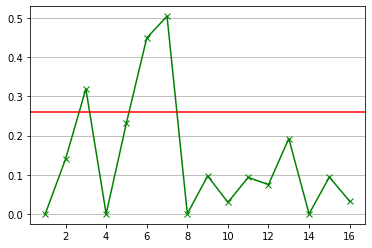

In [ ]:
# Plot

import matplotlib.pyplot as plt

prob_list = []

for i in range(16):
  prob_list.append(pertubed_resnet50_border_collie_prob(i))

x_axis = range(1, 17)

plt.plot(x_axis, prob_list, 'gx-')
plt.axhline(y=0.26, color='r', linestyle='-') # red is the probability given by the undisturbed model
axes = plt.gca()
axes.yaxis.grid()

**A4.3** *Drop each of the 16 `Bottleneck` blocks from the ResNet50 (one at a time, not all at once), and make predictions with each of the perturbed networks. Plot the predicted probability of the Border Collie class (ImageNet class number 232) as a function of the index of the layer dropped. Compare the probabilities you get with the probability for the unperturbed model. What do you see?*

**Answer:**

The original pretrained resnet50 guesses border collie correctly as the 1st option and with prob 0.26453596.

The red line represents the result given by the undisturbed model.
In the plot we can see that the blocks in the 2nd half (from 8 to 16) affect the model's prediction the most. The 1st and the 4th seem to be crucial as without one of them, the probability assigned to border collie is of magnitude $10^{-5}$. Simialarly for the 14th residual block, as removing it gives a prob very close to zero. Removing blocks 3, 6, or 7 improves the prediction of this particular picture and removing 5 doesn't damage the results too much.


Below we're going to try the same thing without setting the weights to zero.
We can see that value-wise we don't get the exact same numbers, but the results are extremely similar, and the difference can't even be seen with the naked eye on the graph.
 



After residual block  1 was dropped:  7.838512e-05
After residual block  2 was dropped:  0.14036655
After residual block  3 was dropped:  0.318958
After residual block  4 was dropped:  1.2559981e-05
After residual block  5 was dropped:  0.23254065
After residual block  6 was dropped:  0.44898984
After residual block  7 was dropped:  0.50438696
After residual block  8 was dropped:  0.018735556
After residual block  9 was dropped:  0.096941754
After residual block  10 was dropped:  0.029635843
After residual block  11 was dropped:  0.09315644
After residual block  12 was dropped:  0.07482927
After residual block  13 was dropped:  0.1922338
After residual block  14 was dropped:  0.00013832505
After residual block  15 was dropped:  0.09406153
After residual block  16 was dropped:  0.032389425


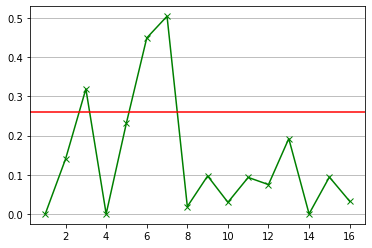

In [ ]:
# Drop each of the 16 Bottleneck blocks from the ResNet50 (one at a time, not all at once), and make predictions with each of the perturbed networks. 
# Plot the predicted probability of the Border Collie class (ImageNet class number 232) as a function of the index of the layer dropped. 
# Compare the probabilities you get with the probability for the unperturbed model. What do you see?

def pertubed_resnet50_border_collie_prob_1(i):
  flat_resnet50 = flatten_resnet(resnet50)

  if(len(list(flat_resnet50.residual_blocks[i].children())) == 8):
    # flat_resnet50.residual_blocks[i].downsample[0].weight.data.fill_(0)
    flat_resnet50.residual_blocks[i].downsample[1] = torch.nn.Identity() # removing the effect of batch norm from downsample
    flat_resnet50.residual_blocks[i] = torch.nn.Sequential(*list(flat_resnet50.residual_blocks[i].children())[7])
  else:
    flat_resnet50.residual_blocks[i] = torch.nn.Identity()

  flat_resnet50.eval()
  y = flat_resnet50(x)
  p = border_collie_prob(y)
  return p[1]
  
# Printing the values

for i in range(16):
  p = pertubed_resnet50_border_collie_prob_1(i)
  print("After residual block ", i+1, "was dropped: ", p)

# Plot
import matplotlib.pyplot as plt

prob_list = []

for i in range(16):
  prob_list.append(pertubed_resnet50_border_collie_prob(i))

x_axis = range(1, 17)

plt.plot(x_axis, prob_list, 'gx-')
plt.axhline(y=0.26, color='r', linestyle='-') # red is the probability given by the undisturbed model
axes = plt.gca()
axes.yaxis.grid()

## Question A.5: Permuting and Repeating Layers

Now, let's see what happens if we permute or repeat layers in the ResNet.

1. Permute layers: Swap `resnet50.layer2[1]` and `resnet50.layer2[3]` in the network (so that instead of the second `Bottleneck` unit in `layer2` you use the fourth and vice versa). Make predictions with the modified network. How did perturbing the model this way modify the predictions?
1. Repeat a residual block in the ResNet. Apply the second `Bottleneck` block of `layer2` of the ResNet twice instead of just once, making the model deeper. Make predictions with the modified model. What do you find?
1. Now repeat the layer 2, 3, 4, 5 times. Do the predictions keep improving?

*15 marks*

### Answers A.5

Please add text in this box, and use as many code cells below as you'd like.

*1. Permute layers. How did perturbing the model this way modify the predictions?*

In this case we can see that the model's predictions for Blas don't change much. The permutation caused it to be more twice as confident in its first choice, which was the correct one, while its confidence in the other options is similar, plus the "tennis ball" as the last option. The higher confidence in the first option means that a lot of other answers are getting a much lower probability than before. Hence this change maybe made cut a bit of the model's generalisation ability.

*2. Repeat a residual block in the ResNet. Apply the second `Bottleneck` block of `layer2` of the ResNet twice instead of just once, making the model deeper. Make predictions with the modified model. What do you find?*

Here again, the model's predictions for Blas weren't affected that much, as the top 5 is still very similar tot the original. It's a bit more confident in Blas than the original model, but it became also almost just as sure that Blas is a Cardigan Welsh Corgi. 

*3. Now repeat the layer 2, 3, 4, 5 times. Do the predictions keep improving?*

We saw tha when we repeat that blottleneck once we get a higher confidence in Border Collie. The trends continues for when we repeat that bottleneck twice, the probability of Border Collie goes up to 0.44. However, after that, the probability of Border Collie goes down exponentially: $ 0.44 (2 repeats) -> 0.004 (3 repeats) -> 1.7\times 10^{-5}(4repeats) -> 1.5\times 10^{-6} (5repeats) -> 1.3\times 10^{-7} (6 repeats) $ and the model becomes more and more confident that Blas is a slot machine, reaching in repeats 5 and 6 confidence of over 0.9 in that.

**A5.1** *Permute layers: Swap `resnet50.layer2[1]` and `resnet50.layer2[3]` in the network (so that instead of the second `Bottleneck` unit in `layer2` you use the fourth and vice versa). Make predictions with the modified network. How did perturbing the model this way modify the predictions?*

In [ ]:
resnet50 = models.resnet50(pretrained=True)
model = copy.deepcopy(resnet50)

tmp = model.layer2[1]
model.layer2[1] = model.layer2[3]
model.layer2[3] = tmp

model.eval()
y = model(x)
print(top_5_classes(y))
print(border_collie_prob(y))

[('Border Collie', 0.52635115), ('collie', 0.19426765), ('Cardigan Welsh Corgi', 0.12698655), ('Australian Kelpie', 0.0908449), ('tennis ball', 0.009584237)]
('Border Collie', 0.52635115)


In [ ]:
model = copy.deepcopy(resnet50)
model.eval()
y = model(x)
print(top_5_classes(y))

[('Border Collie', 0.26453617), ('collie', 0.18160026), ('Cardigan Welsh Corgi', 0.17722456), ('Whippet', 0.12113578), ('Australian Kelpie', 0.05963931)]


**A5.2** *Repeat a residual block in the ResNet. Apply the second `Bottleneck` block of `layer2` of the ResNet twice instead of just once, making the model deeper. Make predictions with the modified model. What do you find?*

In [ ]:
model = copy.deepcopy(resnet50)

print("layer length before:", len(model.layer2))

model.layer2 = torch.nn.Sequential(
      model.layer2[0],
      model.layer2[1],
      model.layer2[1],
      model.layer2[2],
      model.layer2[3],
)

print("layer length after:", len(model.layer2))
model.eval()
y = model(x)
print(top_5_classes(y))
print(border_collie_prob(y))


layer length before: 4
layer length after: 5
[('Border Collie', 0.3159974), ('Cardigan Welsh Corgi', 0.31416893), ('collie', 0.120301306), ('Australian Kelpie', 0.09171227), ('Basenji', 0.031745013)]
('Border Collie', 0.3159974)


**A5.3** *Now repeat the layer 2, 3, 4, 5 times. Do the predictions keep improving?*

In [ ]:
# 2 times

model = copy.deepcopy(resnet50)
print("layer length before:", len(model.layer2))
model.layer2 = torch.nn.Sequential(
      model.layer2[0],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[2],
      model.layer2[3]
)

print("layer length after:", len(model.layer2))
model.eval()
y = model(x)
print(top_5_classes(y))
print(border_collie_prob(y))

layer length before: 4
layer length after: 6
[('Border Collie', 0.44836783), ('Australian Kelpie', 0.18681327), ('Cardigan Welsh Corgi', 0.099308826), ('collie', 0.083472155), ('Basenji', 0.0681161)]
('Border Collie', 0.44836783)


In [ ]:
# 3 times

model = copy.deepcopy(resnet50)
print("layer length before:", len(model.layer2))
model.layer2 = torch.nn.Sequential(
      model.layer2[0],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[2],
      model.layer2[3]
)

print("layer length after:", len(model.layer2))
model.eval()
y = model(x)
print(top_5_classes(y))
print(border_collie_prob(y))

layer length before: 4
layer length after: 7
[('sea slug', 0.321546), ('slot machine', 0.061015215), ('flatworm', 0.056214835), ('Windsor tie', 0.033827472), ('goldfish', 0.02414704)]
('Border Collie', 0.0042771334)


In [ ]:
# 4
model = copy.deepcopy(resnet50)
print("layer length before:", len(model.layer2))
model.layer2 = torch.nn.Sequential(
      model.layer2[0],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[2],
      model.layer2[3]
)

print("layer length after:", len(model.layer2))
model.eval()
y = model(x)
print(top_5_classes(y))
print(border_collie_prob(y))

layer length before: 4
layer length after: 8
[('slot machine', 0.6489886), ('ring-necked snake', 0.04689378), ('lighter', 0.045462977), ('flatworm', 0.030081391), ('goldfish', 0.027000373)]
('Border Collie', 1.7052607e-05)


In [ ]:
# 5
model = copy.deepcopy(resnet50)
print("layer length before:", len(model.layer2))
model.layer2 = torch.nn.Sequential(
      model.layer2[0],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[2],
      model.layer2[3]
)

print("layer length after:", len(model.layer2))
model.eval()
y = model(x)
print(top_5_classes(y))
print(border_collie_prob(y))

layer length before: 4
layer length after: 9
[('slot machine', 0.91281843), ('whistle', 0.038546972), ('lighter', 0.010157909), ('maraca', 0.0053400747), ('goldfish', 0.0034454088)]
('Border Collie', 1.5395034e-06)


In [ ]:
# 6
model = copy.deepcopy(resnet50)
print("layer length before:", len(model.layer2))
model.layer2 = torch.nn.Sequential(
      model.layer2[0],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[1],
      model.layer2[2],
      model.layer2[3]
)

print("layer length after:", len(model.layer2))
model.eval()
y = model(x)
print(top_5_classes(y))
print(border_collie_prob(y))

layer length before: 4
layer length after: 10
[('slot machine', 0.9702782), ('whistle', 0.023643317), ('website', 0.0019537758), ('maraca', 0.0009103248), ('lighter', 0.00084801525)]
('Border Collie', 1.13834545e-07)


# B: Recurrent Networks

In this part of the assignment, we will train simple recurrent networks to detect messages hidden in binary strings.

## Backgroud

### Creating the dataset

Below, I included a function which creates a pytorch `Dataset` we will use in the questions below. 


In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def get_binary_dataset(num_datapoints, signature_length=20, random_length=20):
  '''
  Creates a labelled dataset of `num_datapoints` binary sequences. Each sequence
  is of total length `signature_length + random_length`. Positive examples have
  a signature string of length `signature_length` embedded starting at a random
  location within the string. The signature is a binary string of alternating 1s
  and 0s. Negative examples are random bitstrings. They may contain the
  signature by chance, although the probability of this diminishes as the
  `signature_legth` increases.

  The returned dataset contains positive examples first, followed by negatives.
  When using minibatch-SGD, the dataset has to be shuffled before broken into
  minibatches.
 
  Attributes
  ----------
  num_datapoints : int
    Number of datapoints to be generated. Half of the datapoints will be
    positive, the rest negative. If `num_datapoints==1` then the dataset will
    contain a single positive example.
  signature_length : int
    Length of the signature string
  random_length : int
    Number of random bits in the sequence in addition to the signature sequence.
  
  Returns
  -------
  torch.utils.data.TensorDataset
    Pytorch dataset containing the strings and their binary labels.
  '''
  num_positives = num_datapoints - num_datapoints // 2
  y = np.array([[1.0]]*num_positives + [[0.0]]*(num_datapoints - num_positives))
  X = np.random.randint(2, size=(num_datapoints, signature_length + random_length))
  signature = np.array((signature_length//2)*[1.0, 0.0])
  for i in range(num_positives):
    j = np.random.randint(random_length)
    X[i, j:(j+signature_length)] = signature
  X = torch.tensor(X, dtype=torch.float)[:, :, None]
  y = torch.tensor(y)
  return TensorDataset(X, y)

Below, I visualise a dataset of $100$ positive and $100$ negative sequences of lenth $40$ each. In the visualisation below, positive examples appear on top, negatives in the bottom half. Black pixels show $1$s, white pixels show $0$s. You can see the signature sequence `10101010101010101010` embedded in the positive examples at random locations.

*Notes:* You can see how I used `spy` to visualise a sparse matrix. This function can be used to show non-zero values in a matrix. The pytorch `TensorsDataset` object has a `tensors` attribute which contains the input and output tensors.

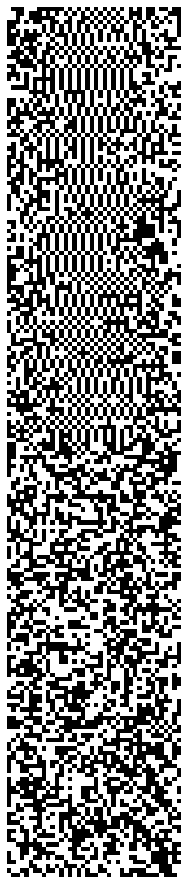

In [ ]:
from matplotlib import pylab as plt

ds = get_binary_dataset(200,
                        signature_length=20,
                        random_length=20)

plt.figure(figsize=(4, 16))
plt.spy(ds.tensors[0][:, :, 0].numpy())
plt.axis('off');

## Building a classifier

Now we're going to build a simple RNN-based classifier for classifying binary sequences. We are going to feed the sequence into an RNN, then extract the hidden state activations at the end of the sequence, finally apply a linear transformation to calculate the classifier output.

An RNN module returns two outputs, as explained in [the documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). We have to select a layer which selects the second output - which is the activation of the hidden state at the end of the sequence - rearranges and flattens it so it's ready to be fed into a linear layer.

*Note:* By applying a further `sigmoid`, this classifier output can be turned into a probability, like it was the case with `softmax` the ResNet example. We are not going to make the sigmoid part of the network, as training will be more numerically stable this way

In [ ]:
import torch.nn as nn

class extract_last_cell(nn.Module):
  '''Pytorch module which extracts and flattens the last hidden state of an RNN.
  '''
  def forward(self,x):
    _ , out = x
    return out.permute(1,0,2).flatten(start_dim=1)

def get_basic_RNN_classifier():
  return nn.Sequential(
    nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True),
    extract_last_cell(),
    nn.Linear(in_features = 20*2, out_features=1)
  )

## Question B.1: Evaluating the loss

Evaluate the log-loss of a randomly initialized classifier on minibatches of training examples from the dataset we defined before.

*Tips:*
* you can use [`pytorch/utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to sample minibatches of training data from the dataset
* or, you can also access the input and output tensors of a `TensorDataset` directly via the `tensors` attribute
* use [`torch.nn.BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.functional.binary_cross_entropy_with_logits`](https://pytorch.org/docs/stable/nn.functional.html)

*10 marks*

### Answer B.1

pleasse add answer in the code cell(s) below:



In [ ]:
from statistics import mean 

dataloader = DataLoader(ds, batch_size = 20, shuffle = True)
rnn = get_basic_RNN_classifier()
criterion = torch.nn.BCEWithLogitsLoss()
total_loss = 0
losses = []

rnn.eval()
# since this is evaluation, there is no need for loss.backward()
for inputs, targets in dataloader:
  outputs = rnn(inputs)
  loss = criterion(outputs, targets)
  print(loss)
  losses.append(loss.item())
  total_loss = total_loss + loss.detach().item()*len(inputs) 

print("Total loss: ", total_loss)   
print("Mean loss: ", mean(losses))
mean(losses) == total_loss/200

tensor(0.6977, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6934, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7017, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6804, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6911, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6834, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7078, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6871, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7005, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6924, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Total loss:  138.71055690944195
Mean loss:  0.6935527845472098


False

#### **B1 observation**
We can see that on average, a random classifier will have a loss of around 0.69. This is true even if the cell above is run multiple times (so when different seeds are being used)

## Training the classifier

In the previous assignment we wrote a training loop to show how optimizers work in pytorch. For this assignment we are going to use ignite, a flexible module for reusable training loops in pytorch. We will install ignite, and then I provide a function you can use to train models on the sequence data.

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 204kB 18.6MB/s 


In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

def fit_model_basic(model, training_dataset, test_dataset):
  '''Fits a pytorch model to the training dataset using stochastic gradient
  descent and tracks progress on a test set.

  Arguments
  ---------
  model : pytorch.nn.Module
    pytorch model that can be evaluated on input tensor in the dataset, and
    returns a tensor that matches the shape of the output tensor.
  training_dataset : pytorch.util.data.Dataset
    used to train the model
  test_dataset : pytorch.util.data.Dataset
    used to evaluate the performance of the model at the end of each epoch

  Retuns
  ------
  pytorch.nn.Module
    the model after training
  '''

  train_loader = DataLoader(
      training_dataset,
      batch_size=100,
      shuffle=True
  )
  val_loader = DataLoader(
      test_dataset,
      batch_size=1000,
      shuffle=False,
  )

  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  criterion = nn.BCEWithLogitsLoss()

  trainer = create_supervised_trainer(model, optimizer, criterion)

  def thresholded_output_transform(output):
      y_pred, y = output
      y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
      return y_pred, y

  val_metrics = {
      "accuracy": Accuracy(thresholded_output_transform),
      "bce": Loss(criterion)
  }
  evaluator = create_supervised_evaluator(model, metrics=val_metrics)

  @trainer.on(Events.ITERATION_COMPLETED(every=10))
  def log_training_loss(trainer):
      print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_training_results(trainer):
      evaluator.run(train_loader)
      metrics = evaluator.state.metrics
      print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_validation_results(trainer):
      evaluator.run(val_loader)
      metrics = evaluator.state.metrics
      print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

  trainer.run(train_loader, max_epochs=5)

  return model

The code above looks rather long and complicated, but that is because we ask ignite to log the progress of training in a very verbose way. Ignite uses python decorators (like the `@trainer.on(Events.EPOCH_COMPLETED)`) bits. You will find plenty of tutorials online if you google 'python decorators' if you want to learn more about them. In ignite, these decorators are used to register functions which are called when various events happen during training.

For example, `@trainer.on(Events.ITERATION_COMPLETED(every=10))` tells ignite to execute the function that's below it every 10th iteration is completed. You will find that this training loop is largely a copy of the example code provided in the [ignite master documentation](https://pytorch.org/ignite/quickstart.html#code).

One difference is that we use the `thresholded_output_transform` to tarnsform the network's output before [`Accuracy`](https://pytorch.org/ignite/metrics.html#ignite.metrics.Accuracy) metric can be evaluated. Accuracy compares binary predictions to binary labels. But our network outputs `logits` instead of binary predictors. To turn these into binary decisions, we have to determine whether the logits are above or below $0$, which is what the `heaviside` function does.

Ignite can do much more than what we ask it to do here. It's a flexible way of creating reproducible training loops for neural network training. It can handle distributed training over several machines, etc.

Let's now use our training loop to train a classifier on the binary dataset we created:

In [ ]:
ds_train = get_binary_dataset(5000, signature_length=10, random_length=10)
ds_test = get_binary_dataset(1000, signature_length=10, random_length=10)
rnn_classifier = get_basic_RNN_classifier()

fit_model_basic(rnn_classifier, ds_train, ds_test)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.55 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Training Results - Epoch: 4  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.49 Avg loss: 0.69
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.68
Epoch[5]

Sequential(
  (0): RNN(1, 20, num_layers=2, batch_first=True)
  (1): extract_last_cell()
  (2): Linear(in_features=40, out_features=1, bias=True)
)

Oh no! The error doesn't seem like the loss is reduced. Let's try to fix this.



## Question B.2: Improving the SGD code

1. Create a new version of `fit_model_basic` function, call it `fit_model`. You will use this function in subsequent questions. Your function should take additional arguments allowing you to easily specify key hyperparameters of optimization: learning rate, batchsize, whatever else you find important.
1. Tune hyperparameters and change things until training works reliably. Consider [changing the optimizer](https://pytorch.org/docs/stable/optim.html) from vanilla SGD: you may try SGD with momentum, `Adam`, etc. You should be able to make this example work, i.e. reach $90\%+$ average accuarcy within a few seconds of training.

*Tips*:
 * You can try different learning rates, such as the [Karpathy constant](https://twitter.com/karpathy/status/801621764144971776). This is a joke, learning rates are usually problem-specific. Values between $0.1$ and $0.001$ are often tried.
 * If you want, you can run grid search: running training for different values of hyperparameters, and checkind which one produces the best results. If doing so, consider spacing parameter values logarithmically rather than linearly. I.e. it makes more sense to try learning rates $[0.001, 0.01, 0.1]$ than to try $[0.001, 0.002, 0.003, \ldots]$.

*15 marks*

### Answer B.2

*Please modify the code in the cells below. You may use this text box to summarise the changes you made.*

**General observation for task B:** We work below with large datasets (5000 instances), hence chances are that the some of the "negative examples" to actually contain a signature. With such large datasets, some of the same sequences (that are truly positive) can find themselves to be labeled as both negative and positive, even in the test set. Hence perfect accuracy is not expected.

**Answer**:
For the 1st task of this question, I chose to add the following hyperparameters of optimisation: learning rate, batch_size, the maximum number of epochs, and the choice of the optimiser. I have also added the choice of a random seed as it can make a difference, as we'll see in the 2nd task. To ensure reproducibility, (following https://pytorch.org/docs/stable/notes/randomness.html), I set *worker_init_fn=seed_worker* inside the dataloaders (just for when we set a seed)

**B2.1** *Create a new version of `fit_model_basic` function, call it `fit_model`. You will use this function in subsequent questions. Your function should take additional arguments allowing you to easily specify key hyperparameters of optimization: learning rate, batchsize, whatever else you find important.*



In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from functools import partial

def fit_model(model, training_dataset, test_dataset, learning_rate = 0.1, batch_size = 100, max_epochs = 5, optim_choice = torch.optim.SGD, seed = None):
  
  if(seed != None):
    torch.manual_seed(seed)

    def seed_worker(worker_id):
      worker_seed = torch.initial_seed() % 2**32
      numpy.random.seed(worker_seed)
      random.seed(worker_seed)

    train_loader = DataLoader(
        training_dataset,
        batch_size = batch_size,
        shuffle=True,
        worker_init_fn=seed_worker
    )
    val_loader = DataLoader(
        test_dataset,
        batch_size = batch_size,
        shuffle=False,
        worker_init_fn=seed_worker
    )

  else: 
    train_loader = DataLoader(
        training_dataset,
        batch_size = batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        test_dataset,
        batch_size = batch_size,
        shuffle=False
    )

  optimizer = optim_choice(model.parameters(), lr=learning_rate)
  criterion = nn.BCEWithLogitsLoss()

  trainer = create_supervised_trainer(model, optimizer, criterion)

  def thresholded_output_transform(output):
      y_pred, y = output
      y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
      return y_pred, y

  val_metrics = {
      "accuracy": Accuracy(thresholded_output_transform),
      "bce": Loss(criterion)
  }
  evaluator = create_supervised_evaluator(model, metrics=val_metrics)

  @trainer.on(Events.ITERATION_COMPLETED(every=10))
  def log_training_loss(trainer):
      print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_training_results(trainer):
      evaluator.run(train_loader)
      metrics = evaluator.state.metrics
      print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_validation_results(trainer):
      evaluator.run(val_loader)
      metrics = evaluator.state.metrics
      print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

  trainer.run(train_loader, max_epochs = max_epochs)

  return model

In [ ]:
ds_train = get_binary_dataset(5000, signature_length=10, random_length=10)
ds_test = get_binary_dataset(1000, signature_length=10, random_length=10)

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test)

# Just as before, we can see that the loss of this classifier with default 
# hyperparameters of learning_rate = 0.1, batch_size = 100, max_epochs = 5, 
# optim_choice = torch.optim.SGD is not different from a random classifier, 
# as no matter the seed (if we run this cell mutiple times), the loss will (most likely) always
# be 0.69, just as a random classifier (from the test in the question B1)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Training Results - Epoch: 1  Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.49 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.70
Training Results - Epoch: 2  Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.68
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.54 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Training Results - Epoch: 4  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.53 Avg loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5]

*2. Tune hyperparameters and change things until training works reliably. Consider [changing the optimizer](https://pytorch.org/docs/stable/optim.html) from vanilla SGD: you may try SGD with momentum, `Adam`, etc. You should be able to make this example work, i.e. reach $90\%+$ average accuarcy within a few seconds of training.*


**Intuition**: Although doing directly a grid search would good, it wouldn't be so experimentative. I want to try a lot of different combinations and judge what is best by looking at the results myself. That way I can get a better idea of what works and what doesn't.

Below I have the lists of values I will try. 
I will first start with looking at all the options for torch.optim.SGD, then for Adam, then for SGD with momentum. 
I will try to play with random seeds sometimes, or run training without setting a seed multiple times to see if I get different results.

In [ ]:
from functools import partial

learning_rate_values = [0.1, 0.01, 0.001]
batch_size_values = [10, 100, 200]
max_epochs_values = [5, 15]
optim_choice_values = [torch.optim.SGD, torch.optim.Adam, partial(torch.optim.SGD, momentum = 0.9)]


#### SGD:

In [ ]:
# learning_rate = 0.1, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.SGD
# here we see no improvement, even if we train multiple times
# makes sense as batch_size is small and learning rate is high
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.SGD)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.78
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.67


In [ ]:
# learning_rate = 0.1, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.SGD
# training for longer
# no improvement
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.SGD)

Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72


In [ ]:
# learning_rate = 0.1, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.SGD
# larger batch_size
# no improvement
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.SGD)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Training Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.69
Training Results - Epoch: 4  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.69
Epoch[5]

In [ ]:
# learning_rate = 0.1, batch_size = 200, max_epochs = 5, optim_choice = torch.optim.SGD
# trying a couple of seeds, as learning rate and batch_size are both high
# even larger batch size
# also see no improvement
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 200, max_epochs = 5, optim_choice = torch.optim.SGD)
print()
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 200, max_epochs = 5, optim_choice = torch.optim.SGD, seed = 88)
print()
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 200, max_epochs = 5, optim_choice = torch.optim.SGD, seed = 10007)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.70
Training Results - Epoch: 3  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Training Results - Epoch: 4  Avg accuracy: 0.55 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.55 Avg loss: 0.69
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.70
Training Results - Epoch: 5  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 5  Avg accuracy: 0.52 Avg loss: 0.69

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Training Results - Epoch: 1  Avg accuracy: 0.48 Avg loss: 0.69
Validation Resul

In [ ]:
# train for longer
# also no loss improvement

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 200, max_epochs = 15, optim_choice = torch.optim.SGD)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Training Results - Epoch: 4  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Training Results - Epoch: 5  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 5  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[6] Loss: 0.69
Epoch[6] Loss: 0.69
Epoch[6] Loss: 0.69
Training Results - Epoch: 6  Avg accuracy: 0.54 Avg loss: 0.

In [ ]:
# learning_rate = 0.01, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.SGD
# move on to next learning_rate of 0.01
# also see no improvement

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.SGD)

Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70


In [ ]:
# learning_rate = 0.01, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.SGD
# train for longer
# also no loss improvement

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.SGD)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69


In [ ]:
# learning_rate = 0.01, batch_size = 100, max_epochs = 5
# larger batch_size
# also no loss improvement
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 100, max_epochs = 5, optim_choice = torch.optim.SGD)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.70
Validation Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.70
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.70
Training Results - Epoch: 2  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.70
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.47 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.49 Avg loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Training Results - Epoch: 4  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5]

In [ ]:
# learning_rate = 0.01, batch_size = 100, max_epochs = 15
# train for longer, try different seeds
# sadly no loss improvement
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.SGD)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.SGD, seed = 88)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.SGD, seed = 10007)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.70
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Training Results - Epoch: 4  Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5]

In [ ]:
# even larger batch_size
# no improvement in either 5 epochs or 15

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 200, max_epochs = 5, optim_choice = torch.optim.SGD)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 200, max_epochs = 15, optim_choice = torch.optim.SGD)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Training Results - Epoch: 4  Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Training Results - Epoch: 5  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 5  Avg accuracy: 0.54 Avg loss: 0.69
----------------------------------------------------------------------
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training 

In [ ]:
# move on to next learning_rate of 0.001
# trying mutiple seeds as both learning rate and batch_size are small
# again, no loss improvement

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.SGD)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.SGD, seed = 88)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.SGD, seed = 10007)

Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68


In [ ]:
# trying out the rest of the options with SGD:
# no improvement here

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.SGD)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 100, max_epochs = 5, optim_choice = torch.optim.SGD)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.SGD)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 200, max_epochs = 5, optim_choice = torch.optim.SGD)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 200, max_epochs = 15, optim_choice = torch.optim.SGD)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68


In [ ]:
# Taking a wild guess that the optimiser might be a problem, as all combinations with simple SGD gave no improvement
# trying ADAM
# for lr = 0.1 we have no improvement, the learning rate is too high
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 100, max_epochs = 5, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 200, max_epochs = 5, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 200, max_epochs = 15, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")

Epoch[1] Loss: 1.36
Epoch[1] Loss: 0.87
Epoch[1] Loss: 0.76
Epoch[1] Loss: 0.42
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.75
Epoch[1] Loss: 1.36
Epoch[1] Loss: 0.76
Epoch[1] Loss: 0.76
Epoch[1] Loss: 1.19
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.88
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.57
Epoch[1] Loss: 0.82
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.91
Epoch[1] Loss: 0.88
Epoch[1] Loss: 0.87
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.87
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.77
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.81
Epoch[1] Loss: 0.96
Epoch[1] Loss: 1.32
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.71
Epoch[1] Loss: 1.05
Epoch[1] Loss: 0.98
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71


In [ ]:
# Adam with lr = 0.01 
# We see improvement only in the last one, which we will try in the next cell with different seeds

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 100, max_epochs = 5, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 200, max_epochs = 5, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 200, max_epochs = 15, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.94
Epoch[1] Loss: 0.99
Epoch[1] Loss: 0.99
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.57
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.81
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.76
Epoch[1] Loss: 0.78
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.81


In [ ]:
# The 1st still has the same result as a random classifier, the 2nd gets down to 0.08, but the 3rd does well, as it gets:
# Training Results - Epoch: 15  Avg accuracy: 0.99 Avg loss: 0.03
# Validation Results - Epoch: 15  Avg accuracy: 0.99 Avg loss: 0.04
# These are reproducible, as long as we use the same ds_train, ds_test, as they have their own random seed

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 200, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 88)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 200, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 10007)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 200, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)
print("----------------------------------------------------------------------")

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[2] Loss: 0.72
Epoch[2] Loss: 0.68
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.53 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.70
Training Results - Epoch: 3  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.53 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.67
Training Results - Epoch: 4  Avg accuracy: 0.53 Avg loss: 0.68
Validation Results - Epoch: 4  Avg accuracy: 0.52 Avg loss: 0.68
Epoch[5] Loss: 0.67
Epoch[5] Loss: 0.68
Training Results - Epoch: 5  Avg accuracy: 0.50 Avg loss: 0.70
Validation Results - Epoch: 5  Avg accuracy: 0.50 Avg loss: 0.70
Epoch[6] Loss: 0.68
Epoch[6] Loss: 0.71
Epoch[6] Loss: 0.69
Training Results - Epoch: 6  Avg accuracy: 0.60 Avg loss: 0.

In [ ]:
# going for lr = 0.001
# learning_rate = 0.001, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.Adam
# loss goes down fast!
# Unlike for lr = 0.01, here the loss goes down regardless of the seed
# Need a bit more training to get convergence
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.Adam, seed = 5)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.Adam, seed = 88)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 5, optim_choice = torch.optim.Adam, seed = 10007)
print("----------------------------------------------------------------------")

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.68


In [ ]:
# Train for longer
# learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam
# This is the best result so far, as both seed 5 and 88 produced perfect accuracy and training and validation loss of 0.02 and the last seed was very close to that. 
# The unknown random seed from the 1st of the 4 did as good as seed 5 and 88.
# Hence these hyperparameters are stable to seed change in producing a very small loss
# both learning rate and batch size are small


classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 88)
print("----------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 10007)
print("----------------------------------------------------------------------")

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70


In [ ]:
# going for a larger batch size and only 5 epochs
# loss is still going down, but we're not doing as well as before
# this is because we increased the batch_size, while having a small learning_rate

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 100, max_epochs = 5, optim_choice = torch.optim.Adam)
print("--------------------------------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 100, max_epochs = 5, optim_choice = torch.optim.Adam, seed = 5)
print("--------------------------------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 100, max_epochs = 5, optim_choice = torch.optim.Adam, seed = 88)
print("--------------------------------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 100, max_epochs = 5, optim_choice = torch.optim.Adam, seed = 10007)
print("--------------------------------------------------------------------------------------------------------------------------------------------")

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Training Results - Epoch: 1  Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[2] Loss: 0.68
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.71
Training Results - Epoch: 2  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.54 Avg loss: 0.69
Epoch[3] Loss: 0.68
Epoch[3] Loss: 0.68
Epoch[3] Loss: 0.70
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.55 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.55 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.68
Training Results - Epoch: 4  Avg accuracy: 0.55 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.55 Avg loss: 0.69
Epoch[5] Loss: 0.68
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.68
Epoch[5]

In [ ]:
# we can try training for longer
# we see good results, but not as good as before

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.Adam)
print("--------------------------------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)
print("--------------------------------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 88)
print("--------------------------------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 100, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 10007)
print("--------------------------------------------------------------------------------------------------------------------------------------------")

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Training Results - Epoch: 1  Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[2] Loss: 0.68
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.71
Training Results - Epoch: 2  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.54 Avg loss: 0.69
Epoch[3] Loss: 0.68
Epoch[3] Loss: 0.68
Epoch[3] Loss: 0.70
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.55 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.55 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.68
Training Results - Epoch: 4  Avg accuracy: 0.55 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.55 Avg loss: 0.69
Epoch[5] Loss: 0.68
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.68
Epoch[5]

In [ ]:
# even larger batch_size
# learning_rate = 0.001, batch_size = 200, max_epochs = 5/15, optim_choice = torch.optim.Adam
# we can now guess that the results below won't be the best 
# not doing so well
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 200, max_epochs = 5, optim_choice = torch.optim.Adam)
print("--------------------------------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 200, max_epochs = 15, optim_choice = torch.optim.Adam)
print("--------------------------------------------------------------------------------------------------------------------------------------------")

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.53 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Training Results - Epoch: 4  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Training Results - Epoch: 5  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 5  Avg accuracy: 0.51 Avg loss: 0.69
------------------------------------------------------------------------------------------------------------------------

In [ ]:
# finally, let's try out a few examples of SGD with momentum
# We can see in this cell and in the next 2 below that even with momentum, SGD is not performing well on this dataset

classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 200, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9))
print("--------------------------------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 200, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9), seed = 5)
print("-------------------------------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 200, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9), seed = 88)
print("-------------------------------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.1, batch_size = 200, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9), seed =  10007)
print("-------------------------------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.48 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.49 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.55 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.54 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.70
Training Results - Epoch: 3  Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.68
Epoch[4] Loss: 0.69
Training Results - Epoch: 4  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.53 Avg loss: 0.69
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.69
Training Results - Epoch: 5  Avg accuracy: 0.55 Avg loss: 0.69
Validation Results - Epoch: 5  Avg accuracy: 0.55 Avg loss: 0.69
Epoch[6] Loss: 0.71
Epoch[6] Loss: 0.69
Epoch[6] Loss: 0.69
Training Results - Epoch: 6  Avg accuracy: 0.52 Avg loss: 0.

In [ ]:
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 100, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9))
print("--------------------------------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 100, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9), seed = 5)
print("-------------------------------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 100, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9), seed = 88)
print("-------------------------------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.01, batch_size = 100, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9), seed =  10007)
print("-------------------------------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.55 Avg loss: 0.69
Epoch[2] Loss: 0.71
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.68
Training Results - Epoch: 2  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.70
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.51 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.68
Epoch[4] Loss: 0.68
Epoch[4] Loss: 0.69
Training Results - Epoch: 4  Avg accuracy: 0.55 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.55 Avg loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5]

In [ ]:
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9))
print("--------------------------------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9), seed = 5)
print("-------------------------------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9), seed = 88)
print("-------------------------------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = partial(torch.optim.SGD, momentum = 0.9), seed =  10007)
print("-------------------------------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67


### B2 Answer

Overall, the best performing and most stable to seed change combination of hyperparameters was:

*learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam*

I will choose seed = 5 for reproducibility

As a mention, I have also trying a batch size of 20 and training for 20 epochs in different combinations, but it looked always like 15 epochs were enought, and the batch size of 10 did better on this learning rate.

## Question B.3: Test on longer sequences

Now that you successfully trained an RNN, let's test how well it works when we use it on longer sequences than what it was trained on. Does it have the ability to remember? Remember we trained on datasets with `signature_length=10, random_length=10`, that is a total length of `20` binary symbols.

* create 5 test datasets with `signature_length` of $10$ but with different `random_length` parameters (e.g. $10$, $20$, $30$, $50$ and $100$)
* evaluate accuracy of your trained model on each of these test regimes - (without retraining!)
* plot the performance you achieve for different test sequence lengths
* describe what you find

*Tips:*
* look inside the `fit_model` function for tips on evaluating models using ignite components.

*20 marks*

### Answers B.3

Please complete the task in code cells below.

In [ ]:
# best model from B2
# we can see it's performing well on other datasets of the parameters
ds_train = get_binary_dataset(5000, signature_length=10, random_length=10)
ds_test = get_binary_dataset(1000, signature_length=10, random_length=10)
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70


In [ ]:
# 1. create 5 test datasets with `signature_length` of $10$ but with different `random_length` parameters (e.g. $10$, $20$, $30$, $50$ and $100$)
ds10 = get_binary_dataset(1000, signature_length=10, random_length=10)
ds20 = get_binary_dataset(1000, signature_length=10, random_length=20)
ds30 = get_binary_dataset(1000, signature_length=10, random_length=30)
ds50 = get_binary_dataset(1000, signature_length=10, random_length=50)
ds100 = get_binary_dataset(1000, signature_length=10, random_length=100)

In [ ]:
def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
    return y_pred, y

In [ ]:
# 2. evaluate accuracy of your trained model on each of these test regimes - (without retraining!)

x_axis = [10, 20, 30, 50, 100]
accuracy = []
loss = []
criterion = nn.BCEWithLogitsLoss()
val_metrics = {
    "accuracy": Accuracy(thresholded_output_transform),
    "bce": Loss(criterion)
}
for i, dataset in enumerate([ds10, ds20, ds30, ds50, ds100]):
  dataloader = DataLoader(dataset, batch_size = 20, shuffle = True)
  classifier.eval() # not really necessary, the evaluator does that, but just to be sure
  evaluator = create_supervised_evaluator(classifier, metrics=val_metrics)
  evaluator.run(dataloader)
  metrics = evaluator.state.metrics
  print(f"Random lenght: {x_axis[i]} Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")
  accuracy.append(metrics['accuracy'])
  loss.append(metrics['bce'])

Random lenght: 10 Avg accuracy: 0.99 Avg loss: 0.05
Random lenght: 20 Avg accuracy: 0.97 Avg loss: 0.12
Random lenght: 30 Avg accuracy: 0.86 Avg loss: 0.77
Random lenght: 50 Avg accuracy: 0.70 Avg loss: 2.06
Random lenght: 100 Avg accuracy: 0.61 Avg loss: 2.67


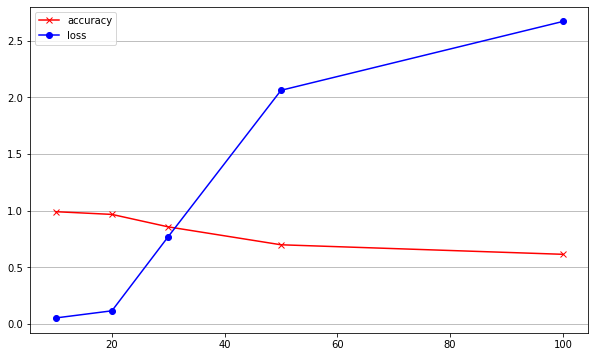

In [ ]:
# 3. plot the performance you achieve for different test sequence lengths

plt.figure(figsize=(10, 6))
plt.plot(x_axis, accuracy,'rx-', label='accuracy')
plt.plot(x_axis, loss, 'bo-', label='loss')
axes = plt.gca()
axes.yaxis.grid()
plt.legend() 

#### 4. describe what you find

The RNN model does really well on data of the same length as the one it was trained on, however, as random_length increases, its performing decreases (loss goes up and accuracy goes down). For random_length = 20, it's still doing pretty well. Still, its accuracy is is always above 50%, so better than random guessing.  

Additionally, accross different runs we see the same trend.

## Question B.4: Better models

Remember what we learned about vanilla RNN's ability to remember information over long time range. Pick a different RNN cell type that should have better ability to remember, and define a new network that uses this cell type. 
* Modify the function below to define an improved RNN classifier
* train an instance of this better RNN model on the same data we trained the previous classifier on
* repeat the analysis from Question 3 using your new model, and contrast your new architecture's performance with the vanilla RNN from before.

*15 marks*

### Answers B.4

Please edit the code below and add as many code cells as you would like to complete this task.

#### B.4 Intuition:

I will first try LSTM, then GRU

#### LSTM

In [ ]:
# 1. Modify the function below to define an improved RNN classifier
class extract_last_cell_1(nn.Module):
  '''Pytorch module which extracts and flattens the last hidden state of an RNN.
  '''
  def forward(self,x):
    _ , out  = x
    return out[0].permute(1,0,2).flatten(start_dim=1)

def get_better_RNN_classifier():
  '''A better RNN architecture for solving the signature detection problem.
  '''
  return nn.Sequential(
    nn.LSTM(input_size=1, hidden_size=20, num_layers=2, batch_first=True),
    extract_last_cell_1(),
    nn.Linear(in_features = 20*2, out_features=1)
  )

In [ ]:
# using the same hyperparameters

classifier = fit_model(get_better_RNN_classifier(), ds_train, ds_test, learning_rate= 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68


In [ ]:
# 3. repeat the analysis from Question 3 using your new model, and contrast your new architecture's performance with the vanilla RNN from before.

def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
    return y_pred, y

x_axis = [10, 20, 30, 50, 100]
accuracy = []
loss = []

criterion = nn.BCEWithLogitsLoss()
val_metrics = {
    "accuracy": Accuracy(thresholded_output_transform),
    "bce": Loss(criterion)
}

for i, dataset in enumerate([ds10, ds20, ds30, ds50, ds100]):
  dataloader = DataLoader(dataset, batch_size = 20, shuffle = True) 
  classifier.eval()

  evaluator = create_supervised_evaluator(classifier, metrics=val_metrics)
  evaluator.run(dataloader)
  metrics = evaluator.state.metrics
  print(f"Random lenght: {x_axis[i]} Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")
  accuracy.append(metrics['accuracy'])
  loss.append(metrics['bce'])

Random lenght: 10 Avg accuracy: 0.99 Avg loss: 0.05
Random lenght: 20 Avg accuracy: 0.99 Avg loss: 0.05
Random lenght: 30 Avg accuracy: 0.94 Avg loss: 0.28
Random lenght: 50 Avg accuracy: 0.80 Avg loss: 1.30
Random lenght: 100 Avg accuracy: 0.68 Avg loss: 2.44


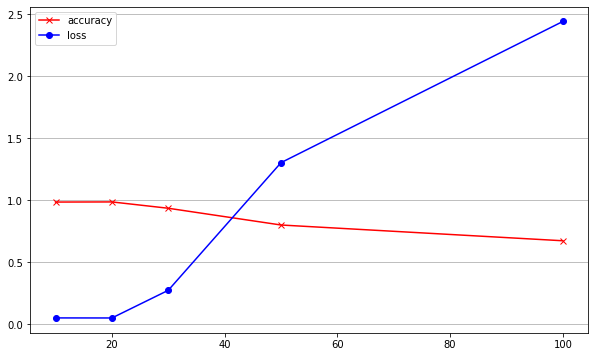

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x_axis, accuracy,'rx-', label='accuracy')
plt.plot(x_axis, loss, 'bo-', label='loss')
axes = plt.gca()
axes.yaxis.grid()
plt.legend() 

**B4 LSTM - compare results:**

Although the loss and the accuracy follow the same trends (loss goes up, accuracy goes down), they do so at a slower rate, given LSTM's ability to memorise. We can see that at each step that this model is doing better than the one before:
(Additionally, just for this training round, for radom_length 20 we have the same accuracy and loss as for random_length 10)

RNN:  
Random lenght: 10 Avg accuracy: 0.99 Avg loss: 0.05  
Random lenght: 20 Avg accuracy: 0.97 Avg loss: 0.12  
Random lenght: 30 Avg accuracy: 0.86 Avg loss: 0.77  
Random lenght: 50 Avg accuracy: 0.70 Avg loss: 2.06    
Random lenght: 100 Avg accuracy: 0.61 Avg loss: 2.67  

LSTM:  
Random lenght: 10 Avg accuracy: 0.99 Avg loss: 0.05  
Random lenght: 20 Avg accuracy: 0.99 Avg loss: 0.05  
Random lenght: 30 Avg accuracy: 0.94 Avg loss: 0.28  
Random lenght: 50 Avg accuracy: 0.80 Avg loss: 1.30  
Random lenght: 100 Avg accuracy: 0.68 Avg loss: 2.44  

#### GRU

In [ ]:
# 1. Modify the function below to define an improved RNN classifie
# GRU
def get_better_RNN_classifier():
  '''A better RNN architecture for solving the signature detection problem.
  '''
  return nn.Sequential(
    nn.GRU(input_size=1, hidden_size=20, num_layers=2, batch_first=True), 
    extract_last_cell(),
    nn.Linear(in_features = 20*2, out_features=1)
  )

In [ ]:
# 2. train an instance of this better RNN model on the same data we trained the 
# using the same winner as before
classifier = fit_model(get_better_RNN_classifier(), ds_train, ds_test, learning_rate= 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68


In [ ]:
# 3. repeat the analysis from Question 3 using your new model, and contrast your new architecture's performance with the vanilla RNN from before.
# GRU
def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
    return y_pred, y

x_axis = [10, 20, 30, 50, 100]
accuracy = []
loss = []

criterion = nn.BCEWithLogitsLoss()
val_metrics = {
    "accuracy": Accuracy(thresholded_output_transform),
    "bce": Loss(criterion)
}

for i, dataset in enumerate([ds10, ds20, ds30, ds50, ds100]):
  dataloader = DataLoader(dataset, batch_size = 20, shuffle = True)
  classifier.eval()

  evaluator = create_supervised_evaluator(classifier, metrics=val_metrics)
  evaluator.run(dataloader)
  metrics = evaluator.state.metrics
  print(f"Random lenght: {x_axis[i]} Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")
  accuracy.append(metrics['accuracy'])
  loss.append(metrics['bce'])

Random lenght: 10 Avg accuracy: 0.97 Avg loss: 0.09
Random lenght: 20 Avg accuracy: 0.85 Avg loss: 0.83
Random lenght: 30 Avg accuracy: 0.75 Avg loss: 1.78
Random lenght: 50 Avg accuracy: 0.63 Avg loss: 2.81
Random lenght: 100 Avg accuracy: 0.58 Avg loss: 3.24


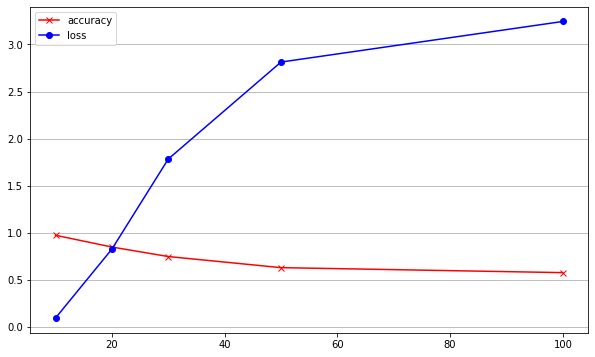

In [ ]:
# GRU
plt.figure(figsize=(10, 6))
plt.plot(x_axis, accuracy,'rx-', label='accuracy')
plt.plot(x_axis, loss, 'bo-', label='loss')
axes = plt.gca()
axes.yaxis.grid()
plt.legend() 

**B4 GRU - compare results:**

The results of applying GRU are more similar to those of RNN than to those of LSTM, at least in the examples I have run here. By looking at the numbers here, GRU performs the worst (but I ran this a few times and I also got similar results to RNN, but always below LSTM)

RNN:  
Random lenght: 10 Avg accuracy: 0.99 Avg loss: 0.05  
Random lenght: 20 Avg accuracy: 0.97 Avg loss: 0.12  
Random lenght: 30 Avg accuracy: 0.86 Avg loss: 0.77  
Random lenght: 50 Avg accuracy: 0.70 Avg loss: 2.06    
Random lenght: 100 Avg accuracy: 0.61 Avg loss: 2.67  

LSTM:  
Random lenght: 10 Avg accuracy: 0.99 Avg loss: 0.05  
Random lenght: 20 Avg accuracy: 0.99 Avg loss: 0.05  
Random lenght: 30 Avg accuracy: 0.94 Avg loss: 0.28  
Random lenght: 50 Avg accuracy: 0.80 Avg loss: 1.30  
Random lenght: 100 Avg accuracy: 0.68 Avg loss: 2.44    

GRU:  
Random lenght: 10 Avg accuracy: 0.97 Avg loss: 0.09  
Random lenght: 20 Avg accuracy: 0.85 Avg loss: 0.83  
Random lenght: 30 Avg accuracy: 0.75 Avg loss: 1.78  
Random lenght: 50 Avg accuracy: 0.63 Avg loss: 2.81  
Random lenght: 100 Avg accuracy: 0.58 Avg loss: 3.24    

**B4** Below I try more and less hidden_layers and layers

In [ ]:
#### More hidden_layers and layers
# 1. Modify the function below to define an improved RNN classifie

def get_better_RNN_classifier():
  '''A better RNN architecture for solving the signature detection problem.
  '''
  return nn.Sequential(
    nn.GRU(input_size=1, hidden_size=100, num_layers=10, batch_first=True),
    extract_last_cell(),
    nn.Linear(in_features = 100*10, out_features=1)
  )

In [ ]:
# 2. train an instance of this better RNN model on the same data we trained the 
# using the same winner as before
classifier = fit_model(get_better_RNN_classifier(), ds_train, ds_test, learning_rate= 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68


In [ ]:
# 3. repeat the analysis from Question 3 using your new model, and contrast your new architecture's performance with the vanilla RNN from before.

def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
    return y_pred, y

x_axis = [10, 20, 30, 50, 100]
accuracy = []
loss = []

criterion = nn.BCEWithLogitsLoss()
val_metrics = {
    "accuracy": Accuracy(thresholded_output_transform),
    "bce": Loss(criterion)
}

for i, dataset in enumerate([ds10, ds20, ds30, ds50, ds100]):
  dataloader = DataLoader(dataset, batch_size = 20, shuffle = True)
  classifier.eval()

  evaluator = create_supervised_evaluator(classifier, metrics=val_metrics)
  evaluator.run(dataloader)
  metrics = evaluator.state.metrics
  print(f"Random lenght: {x_axis[i]} Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")
  accuracy.append(metrics['accuracy'])
  loss.append(metrics['bce'])

Random lenght: 10 Avg accuracy: 0.99 Avg loss: 0.04
Random lenght: 20 Avg accuracy: 0.77 Avg loss: 1.59
Random lenght: 30 Avg accuracy: 0.69 Avg loss: 2.29
Random lenght: 50 Avg accuracy: 0.60 Avg loss: 3.23
Random lenght: 100 Avg accuracy: 0.56 Avg loss: 3.61


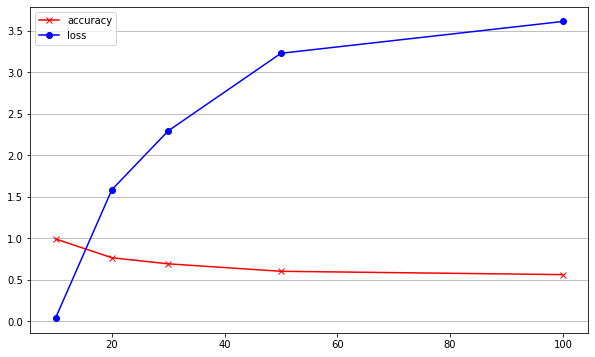

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x_axis, accuracy,'rx-', label='accuracy')
plt.plot(x_axis, loss, 'bo-', label='loss')
axes = plt.gca()
axes.yaxis.grid()
plt.legend() 

**Less hidden layers**

In [ ]:
# Now trying less hidden layers, because I noticed when doing the C miniproject 
# that when using hidden_size = 20 and training on longer sequences, the model 
# performed well, so I thought a smaller hidden_size value could perform better here 

def get_better_RNN_classifier():
  '''A better RNN architecture for solving the signature detection problem.
  '''
  return nn.Sequential(
    nn.GRU(input_size=1, hidden_size=10, num_layers=2, batch_first=True),
    extract_last_cell(),
    nn.Linear(in_features = 10*2, out_features=1)
  )

classifier = fit_model(get_better_RNN_classifier(), ds_train, ds_test, learning_rate= 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)  

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68


In [ ]:
def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
    return y_pred, y

x_axis = [10, 20, 30, 50, 100]
accuracy = []
loss = []

criterion = nn.BCEWithLogitsLoss()
val_metrics = {
    "accuracy": Accuracy(thresholded_output_transform),
    "bce": Loss(criterion)
}

for i, dataset in enumerate([ds10, ds20, ds30, ds50, ds100]):
  dataloader = DataLoader(dataset, batch_size = 20, shuffle = True) 
  classifier.eval()

  evaluator = create_supervised_evaluator(classifier, metrics=val_metrics)
  evaluator.run(dataloader)
  metrics = evaluator.state.metrics
  print(f"Random lenght: {x_axis[i]} Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")
  accuracy.append(metrics['accuracy'])
  loss.append(metrics['bce'])

Random lenght: 10 Avg accuracy: 0.97 Avg loss: 0.10
Random lenght: 20 Avg accuracy: 0.97 Avg loss: 0.10
Random lenght: 30 Avg accuracy: 0.97 Avg loss: 0.13
Random lenght: 50 Avg accuracy: 0.97 Avg loss: 0.12
Random lenght: 100 Avg accuracy: 0.90 Avg loss: 0.55


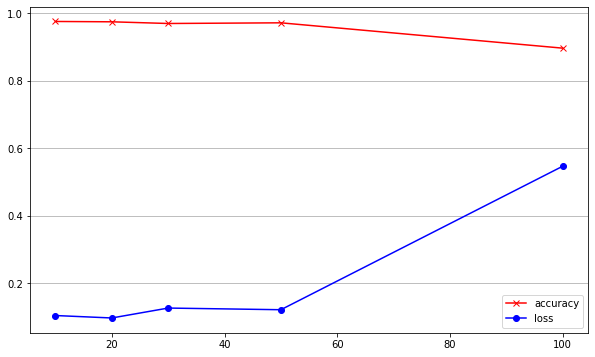

In [ ]:
import numpy as np
from matplotlib import pylab as plt

plt.figure(figsize=(10, 6))
plt.plot(x_axis, accuracy,'rx-', label='accuracy')
plt.plot(x_axis, loss, 'bo-', label='loss')
axes = plt.gca()
axes.yaxis.grid()
plt.legend() 

**B4 hidden_layers comparison**

We can see above that trying out more hidden_layers and more layers actually produced results somewhat similar to before.


When training with less hidden layers we see that the model doesn't have time to forget, and over all datasets we get the best performing model of all, (even accross multiple runs). It does impressively well.

## Question B.5: Visualise memorization

Now we are going to visualize which parts of the input the trained architecture pays attention to when making its decision. This is going to be similar in spirit to [this distill post](https://distill.pub/2019/memorization-in-rnns/).
* take your pre-trained RNN classifier from the previous example
* generate a random positive input sequence (one that has a signature of length $10$ in it) and form an input tensor to the model.
* calculate the gradient of the model's output with respect to the input.
* plot the magnitude of the gradient $|\frac{\partial \mathbf{h}_T}{\partial x_t}|$ with respect to each digit in the input sequence, as a function of index $t$.
* Redo the plot above for multiple input sequences. Interpret what you see and document your findings. If helpful, use different ways of plotting to better illustrate the point.

*Tips:*
* remember how we used `requires_grad` and `backward` and the `grad` attribute in the lecture to calculate the gradients of an RNN's hidden state with respect to the input sequence.
* remember the `TensorDataset` has a `tensors` argument which you can use to extract the input and output tensors from the dataset.

*15 marks*

### Answers B.5

Please add your solution to the code blocks below.

In [ ]:
# 1. take your pre-trained RNN classifier from the previous example
my_gru = classifier

In [ ]:
# 2. generate a random positive input sequence (one that has a signature of length $10$ in it) and form an input tensor to the model
# remember the `TensorDataset` has a `tensors` argument which you can use to extract the input and output tensors from the dataset.
input_and_label = get_binary_dataset(num_datapoints = 1,
                        signature_length=10,
                        random_length=10)
input = input_and_label.tensors[0]
print(torch.flatten(input))

tensor([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0.])


In [ ]:
# 3. calculate the gradient of the model's output with respect to the input
input = input_and_label.tensors[0]
input.requires_grad = True
output = my_gru(input)
print(output.size())
output[0, 0].backward()
input.grad.size()

torch.Size([1, 1])


torch.Size([1, 20, 1])

In [ ]:
torch.flatten(input.grad)

tensor([ 0.1774,  0.1084,  0.3076, -0.2476,  0.8747, -0.5509,  1.7842, -2.9389,
         2.9600, -4.1372,  2.9829, -4.3416,  2.0550, -2.9115,  0.7124, -0.8664,
        -0.0632, -0.1869, -0.4211,  0.0045])

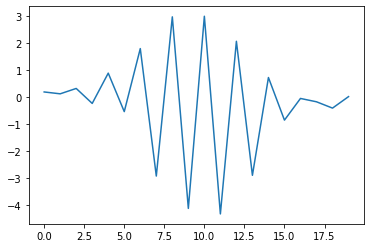

In [ ]:
# we can see a bit that the hidden layer activations are sensitive to the position of the signature which we can see above
plt.plot(input.grad[0,:,0].detach().numpy())

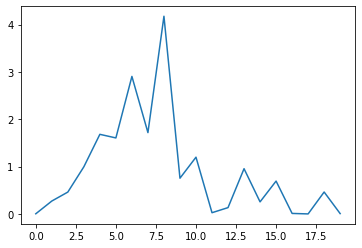

In [ ]:
plt.plot(input.grad[0,:,0].detach().numpy()**2)

In [ ]:
my_gru[0]

GRU(1, 10, num_layers=2, batch_first=True)

torch.Size([1, 20, 10])
torch.Size([1, 20, 1])


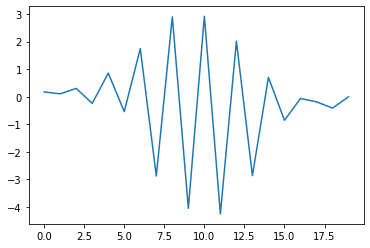

In [ ]:
# Looking directly at the output of the GRU layer
# Since the only difference is an a linear layer, the plots look similar, but the valus may not be exactly the same
input = input_and_label.tensors[0]
input.requires_grad = True
out, _ = my_gru[0](input)
print(out.size()) # 1 is the sequence length (but in our case a sequence is a tensor of 1 element lists, so 20 is the actual input size), the last 20 is from the hidden_size
out[0, 19, 0].backward()
print(input.grad.size())
plt.plot(input.grad[0,:,0].detach().numpy())

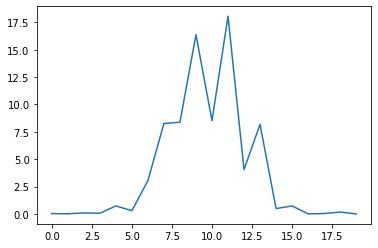

In [ ]:
plt.plot(input.grad[0,:,0].detach().numpy()**2)

In [ ]:
torch.flatten(input.grad)

tensor([ 1.7334e-01,  1.0596e-01,  3.0097e-01, -2.4213e-01,  8.5546e-01,
        -5.3848e-01,  1.7449e+00, -2.8740e+00,  2.8951e+00, -4.0466e+00,
         2.9185e+00, -4.2498e+00,  2.0138e+00, -2.8606e+00,  7.0034e-01,
        -8.5511e-01, -6.4550e-02, -1.8526e-01, -4.1345e-01, -2.7245e-03])

In [ ]:
# 5. Redo the plot above for multiple input sequences. 
# Interpret what you see and document your findings. 
# If helpful, use different ways of plotting to better illustrate the point.

In [ ]:
# I will work with the square values to get a better idea to what part of the input the hidden layers are most sensitive to
def plot_example(random_length, signature_length = 10):
  input_and_label = get_binary_dataset(num_datapoints = 1,
                          signature_length = signature_length,
                          random_length=random_length)
  input = input_and_label.tensors[0]
  print(torch.flatten(input))
  input.requires_grad = True
  output = my_gru(input)
  output[0, 0].backward()
  input.grad.size()
  plt.figure(figsize=(10, 6))
  plt.plot(input.grad[0,:,0].detach().numpy()**2,color='#bc5090', linestyle='dashed', marker='.', markerfacecolor='#003f5c', markersize=12)

tensor([1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.])


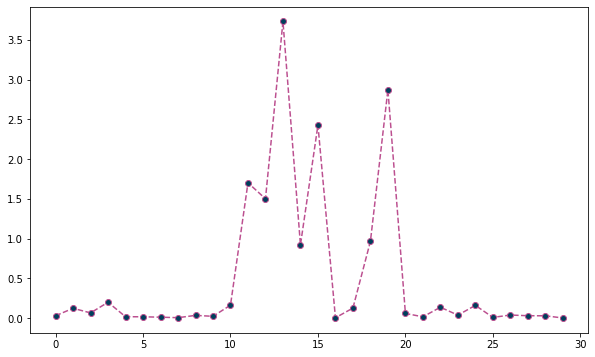

In [ ]:
# random_length=20
plot_example(20)

tensor([0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0.])


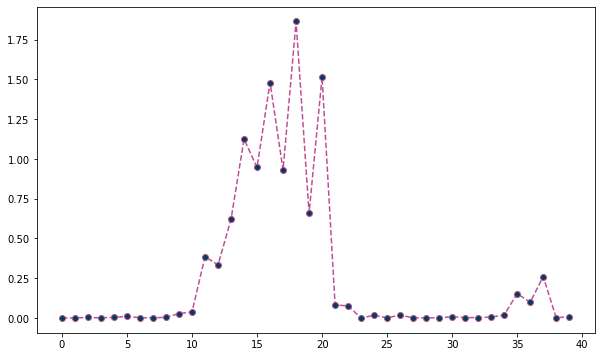

In [ ]:
plot_example(30)

tensor([0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.])


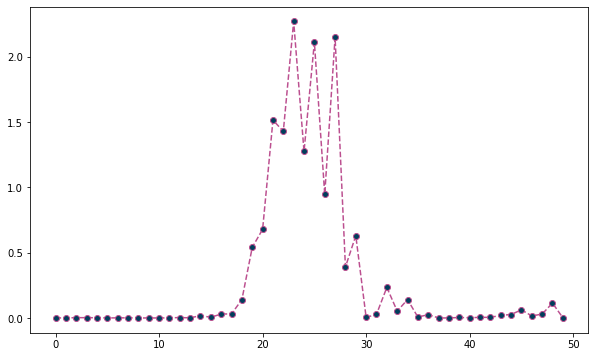

In [ ]:
plot_example(40)

tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 1., 0.])


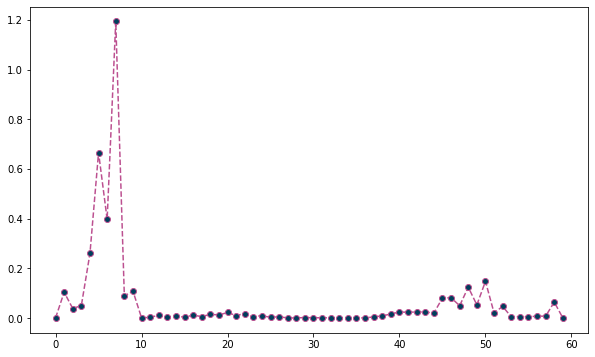

In [ ]:
plot_example(50)

tensor([1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.])


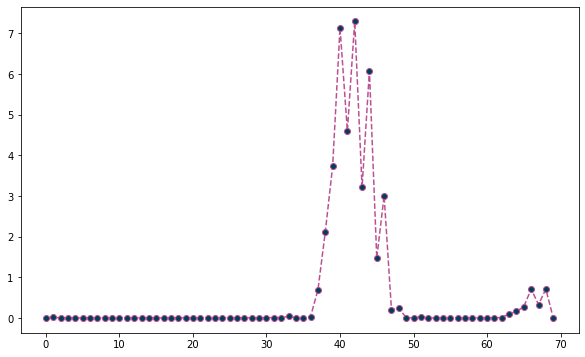

In [ ]:
plot_example(60)

tensor([0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 0.])


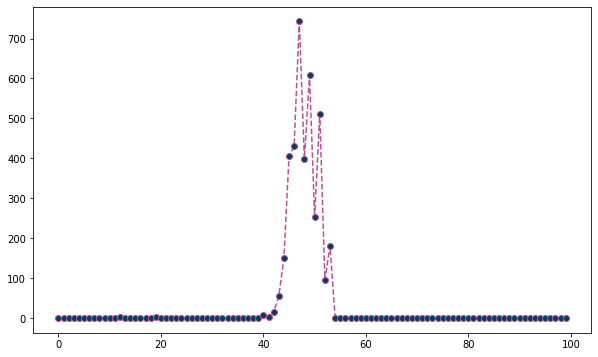

In [ ]:
plot_example(90)

tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 1.])


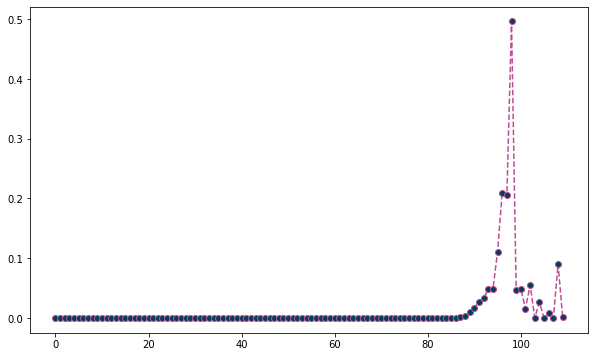

In [ ]:
plot_example(100)

tensor([0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 0.])


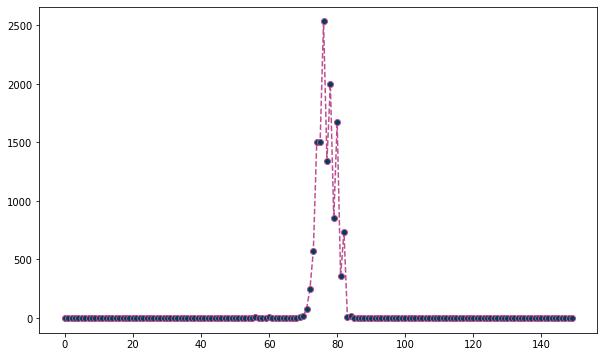

In [ ]:
plot_example(140)

tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
        1., 0.])


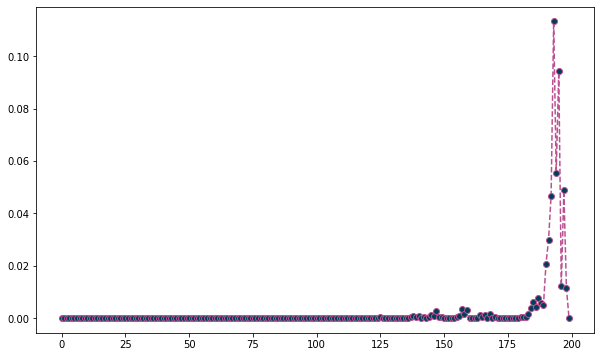

In [ ]:
plot_example(190)

tensor([0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.])


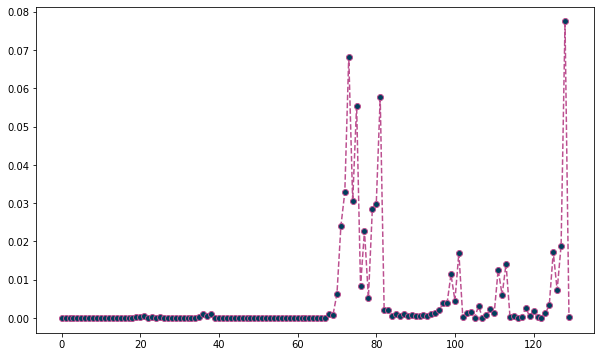

In [ ]:
plot_example(100, 30)

**B5** *Interpret what you see and document your findings.*

**Answer**  
By looking at the plots we can see that no matter the length of the sequence, the 10-bit signature is the point where the activations are very sensitive to the position of the sequence, as the gradients are very close to zero almost everywhere and they explode for a period of around 10 points on the axis, In the one with random_length = 50 we can from the printing that the signature is at the beginning of the sequence, and from the plot that the gradients are visibly larger above zero exactly from positions 0 to 9 on the x axis. And then later on there is another smaller spike. Smaller spikes are caused by random shorter signatures or possibly by random subsequences that are similar to the signature, however, they are never as significant as the actual signature.

In the last plot we look at an example where the signature length is 30,  not 10 and we can see multiple spikes, but not an visible interval of the signature's length with a spike more siginificant than the others.

If we look at the other plots and the printed input we can see that the position on the signature in the input matches the position of the largest spike on the graph.

As an observations, the magnitudes of the y axis vary from very small to very large values from one plot to the other.


**B5**   
Below I also plot some examples using LSTM with 20 hidden layers, so to keep the original parameters, as I'm not sure if I was supposed to change them in this section or not. From the models with hidden_size = 20, LSTM performed the best.  
**Observation:** We can see the same behaviour as in our plots for GRU with 10 hidden_layers. The spikes are present at the position of the signature.

In [ ]:
# using the same hyperparameters
# 1. Modify the function below to define an improved RNN classifier
class extract_last_cell_1(nn.Module):
  '''Pytorch module which extracts and flattens the last hidden state of an RNN.
  '''
  def forward(self,x):
    _ , out  = x
    return out[0].permute(1,0,2).flatten(start_dim=1)

def get_better_RNN_classifier():
  '''A better RNN architecture for solving the signature detection problem.
  '''
  return nn.Sequential(
    nn.LSTM(input_size=1, hidden_size=20, num_layers=2, batch_first=True),
    extract_last_cell_1(),
    nn.Linear(in_features = 20*2, out_features=1)
  )
  
my_lstm = fit_model(get_better_RNN_classifier(), ds_train, ds_test, learning_rate= 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68


In [ ]:
def plot_lstm_example(random_length, signature_length = 10):
  input_and_label = get_binary_dataset(num_datapoints = 1,
                          signature_length = signature_length,
                          random_length=random_length)
  input = input_and_label.tensors[0]
  print(torch.flatten(input))
  input.requires_grad = True
  output = my_lstm(input)
  output[0, 0].backward()
  input.grad.size()
  plt.figure(figsize=(10, 6))
  plt.plot(input.grad[0,:,0].detach().numpy()**2,color='#bc5090', linestyle='dashed', marker='.', markerfacecolor='#003f5c', markersize=12)

tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        1., 1.])


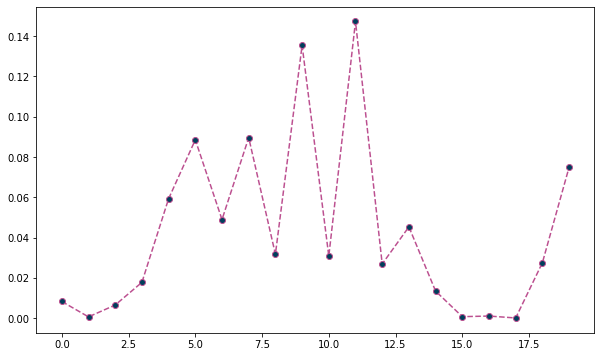

In [ ]:
plot_lstm_example(10)

tensor([1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.])


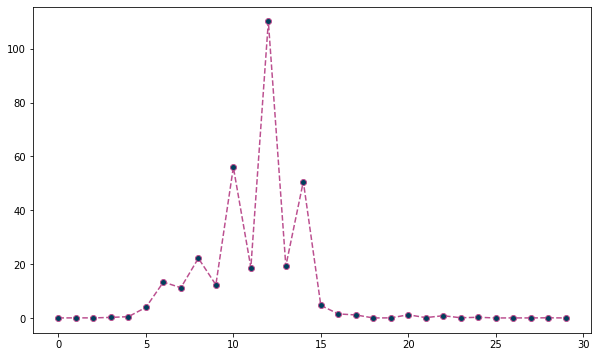

In [ ]:
plot_lstm_example(20)

tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])


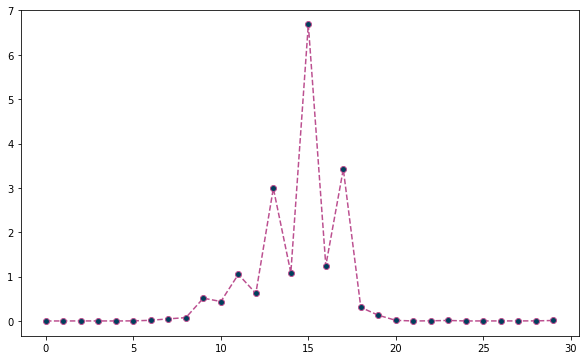

In [ ]:
plot_lstm_example(20)

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0.])


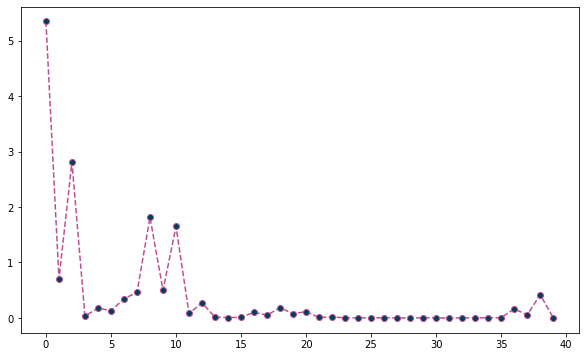

In [ ]:
plot_lstm_example(30)

tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.])


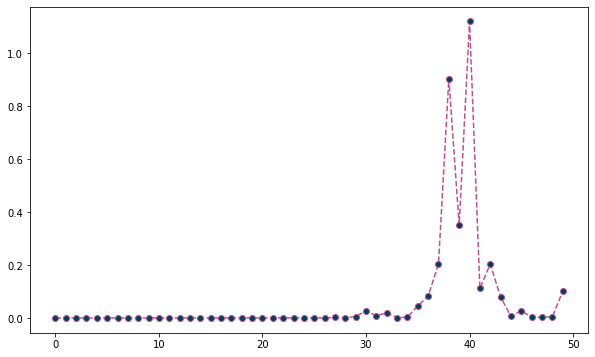

In [ ]:
plot_lstm_example(40)

tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 0., 0.])


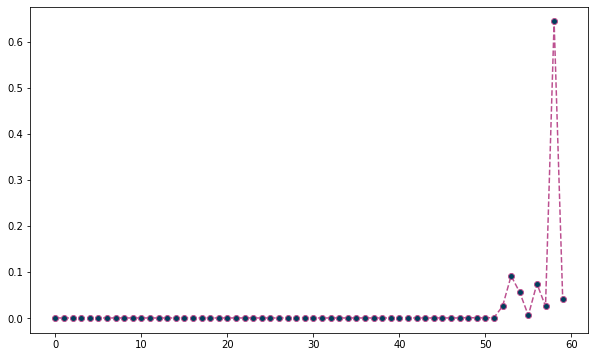

In [ ]:
plot_lstm_example(50)

tensor([1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 1.])


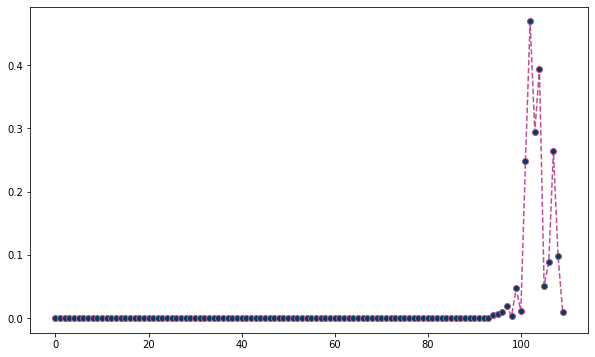

In [ ]:
plot_lstm_example(100)

## C Mini-Projects

Please **choose one** of the proposed mini-project questions below. Add as many text and code cells under the heading as you'd like. You may attempt more than one, but we will only mark one: please write below which mini-project you'd like to get marked on:

**I would like my solution for mini-project C2 to be marked.**

## C.2: Extend on binary sequence learning from questions B

Building on the quided question set B on Recurrent Neural Networks, explore what RNNs and different models can do on the binary string datasets. You can try the following
* Make the task more difficult (for this, extend `get_binary_dataset`):
  * Can you successfully train networks on longer training sequences? *(~10 marks)*
  * What happens if you add noise to the data, e.g. randomly flip bits?  *(~20 marks)*
  * Embed more than one copy of the signature sequence, can you train a network to count them?  *(~20 marks)*
  * Can networks memorise messages emmbedded in random bit strings. For example, can you train a Seq2Seq network recover k random bits that immediately follow the signature sequence?  *(~40 marks)*
* Try different architectures:
  * What architectures, other than RNNs could solve this problem well? Do you need deep architectures? Design another model and train it on the binary dataset. Can you get them to solve the problem? Can you illustrate the pros and cons of different architectures for this problem? *(~30 marks for one architecture, up to ~70 marks for trying and comparing substantially different architectures in a good writeup)*
* Hand design neural networks that solve this problem:
  * This problem can be solved with simple algorithms. Implement these algorithms in neural hardware, i.e. by manually setting weights in a neural network. *(~40 marks)*

*Tips:*
  * For counting, you might want to think about what an appropriate loss function is. You can set this up as a multiclass classification problem and use [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Think about how the network's output has to change.
  * When changing architectures substantially, you may find that the same optimization hyperparameters no longer work.
  * pytorch RNN modules return two outputs, if you want to use attention, you want the first output (cell values at the top layer at all timesteps), for vanilla seq2seq or classification you need the second output (hidden states at all layers at the final timestep)

*80 marks*

**C2.1.1** *Can you successfully train networks on longer training sequences? *(~10 marks)**

For this I choose to work with GRU and keep hidden_layer = 20

In [ ]:
import torch.nn as nn

class extract_last_cell(nn.Module):
  '''Pytorch module which extracts and flattens the last hidden state of an RNN.
  '''
  def forward(self,x):
    _ , out = x
    return out.permute(1,0,2).flatten(start_dim=1)

def get_GRU_classifier():
  return nn.Sequential(
    nn.GRU(input_size=1, hidden_size=20, num_layers=2, batch_first=True),
    extract_last_cell(),
    nn.Linear(in_features = 20*2, out_features=1)
  )

In [ ]:
ds_train = get_binary_dataset(5000, signature_length=20, random_length=20)
ds_test = get_binary_dataset(1000, signature_length=20, random_length=20)

# This achieves perfect accuracy and zero loss, this might be possibly correct as such a long signature is harder to randomly come by in order for our dataset to have a false negative value in it.
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69


In [ ]:
# trying other seeds
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 88)
print("-------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 10007)
print("-------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70


In [ ]:
# try longer random_lengths

ds_train = get_binary_dataset(5000, signature_length=30, random_length=30)
ds_test = get_binary_dataset(1000, signature_length=30, random_length=30)

classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 5)
print("-------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 88)
print("-------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 10007)
print("-------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69


In [ ]:
# try longer random_lengths

ds_train = get_binary_dataset(5000, signature_length=20, random_length=40)
ds_test = get_binary_dataset(1000, signature_length=20, random_length=40)

classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 5)
print("-------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 88)
print("-------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 10007)
print("-------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69


In [ ]:
ds_train = get_binary_dataset(5000, signature_length=30, random_length=100)
ds_test = get_binary_dataset(1000, signature_length=30, random_length=100)

classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 5)
print("-------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 88)
print("-------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 10007)
print("-------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69


In [ ]:
ds_train = get_binary_dataset(5000, signature_length=10, random_length=50)
ds_test = get_binary_dataset(1000, signature_length=10, random_length=50)

# This achieves perfect accuracy and zero loss, this might be possibly correct as such a long signature is harder to randomly come by in order for our dataset to have a false negative value in it.
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69


In [ ]:
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 88)
print("-------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 10007)
print("-------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69


**C2.1.1**  

**Answer:**  We can see that the GRU model is doing fine with longer sequences, when we vary both signature_length and random_length, and it's doing so on multiple seeds, so it's stable.

I suspect the reason why it's doing well with these sequences is because I used longer signature lengths and this decreases the chance of a random signature appearing in the negative pile, hence the datasets are cleaner than before. 

Summary of the examples above:  
(signature, random)  
20, 20: zero loss on all 3 seeds  
30, 30: zero loss on all 3 seeds  
20, 40: almost zero loss on all 3  
30, 100: seed 88 isn't making the model learn. But we can see by looking at the epochs in this situation that the model is learning very late (for seed 5 loss went down only in epoch 14 and for seed 10007 it went down in epoch 15). Hence if we want to train on even longer sequences than this, we would have to maybe train for longer.  

We can see the bad influence of short signatures in the last example. We have set random length to 50 (used to be 10) and left signature_length = 10 and we still have 5000 inputs, hence we have more scope for random unwanted signatures. We can see that in comparison to (20, 40), this (10, 50) combination isn't being learnt so fast or doing well under more seed. The loss is going down very slowly. This is due to the mislabeled data confusing the model.

Nevertheless, given enough time and a reasonable length signature the model will be able to learn on longer sequences.


**C2.1.2** *What happens if you add noise to the data, e.g. randomly flip bits?*  *(~20 marks)*

In [ ]:
""" Approach:
noise_level = the number of maximum bits to be flipped

We choose a random number noisy_count in [0, noise_level] to get the number of noisy bits to be added.
Then we choose noisy_count positions in the sequence and we flip those.
We apply the noise to both positive and negative examples. 
The noise on positive examples may or may not affect the signature.
The noise in negative examples (or in positive ones but outside the signature) 
may cause the appearance of false signatures.

"""
import torch
import random
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def get_noisy_binary_dataset(num_datapoints, signature_length=20, random_length=20, noise_level = 5):

  num_positives = num_datapoints - num_datapoints // 2
  y = np.array([[1.0]]*num_positives + [[0.0]]*(num_datapoints - num_positives))
  X = np.random.randint(2, size=(num_datapoints, signature_length + random_length))
  signature = np.array((signature_length//2)*[1.0, 0.0])
  

  for i in range(num_positives):
    j = np.random.randint(random_length)
    X[i, j:(j+signature_length)] = signature

  # add noise
  for i in range(num_datapoints):  
    # choose a number of bits to flip
    noisy_count = random.randint(0, noise_level) # random.randint is not the same as np.random.randint, this one can output noise_level as well
    # choose random positions to be flipped
    noise_positions = random.sample(range(signature_length + random_length), noisy_count)
    for k in noise_positions:
      if X[i, k] == 0.0:
        X[i, k] = 1.0
      else:
        X[i, k] = 0.0
      
  X = torch.tensor(X, dtype=torch.float)[:, :, None]
  y = torch.tensor(y)
  return TensorDataset(X, y)

In [ ]:
# noise_level = 5
ds_train = get_noisy_binary_dataset(5000, signature_length=10, random_length=10, noise_level = 5)
ds_test = get_noisy_binary_dataset(1000, signature_length=10, random_length=10, noise_level = 5)

In [ ]:
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam)
print("--------------------------------------------------------------------------------------------------------------------")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 5)
print("-------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 88)
print("-------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 10007)
print("-------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70


In [ ]:
# noise_level = 10
ds_train = get_noisy_binary_dataset(5000, signature_length=10, random_length=10, noise_level = 10)
ds_test = get_noisy_binary_dataset(1000, signature_length=10, random_length=10, noise_level = 10)

In [ ]:
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 5)
print("-------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 88)
print("-------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 10007)
print("-------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70


In [ ]:
# noise_level = 15 for longer sequences
ds_train = get_noisy_binary_dataset(5000, signature_length=20, random_length=20, noise_level = 15)
ds_test = get_noisy_binary_dataset(1000, signature_length=20, random_length=20, noise_level = 15)

classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 5)
print("-------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 88)
print("-------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 10007)
print("-------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69


In [ ]:
ds_train = get_noisy_binary_dataset(5000, signature_length=30, random_length=40, noise_level = 20)
ds_test = get_noisy_binary_dataset(1000, signature_length=30, random_length=40, noise_level = 20)

classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 5)
print("-------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 88)
print("-------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 10007)
print("-------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69


In [ ]:
ds_train = get_noisy_binary_dataset(5000, signature_length=30, random_length=30, noise_level = 15)
ds_test = get_noisy_binary_dataset(1000, signature_length=30, random_length=30, noise_level = 15)

classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 5)
print("-------------------------------------------------------------------------------------------------------------------- 5")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 88)
print("-------------------------------------------------------------------------------------------------------------------- 88")
classifier = fit_model(get_GRU_classifier(), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice = torch.optim.Adam, seed = 10007)
print("-------------------------------------------------------------------------------------------------------------------- 10007")

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.75
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69


**C2.1.2**  
**Answer**  

 (signature_length, random_length, noise_level):  
10, 10, 5: consistent results of accuracy around 0.8 and loss around 0.4  
Noise level represents a maximum number of corrupt bits. Which means that a small noise level equals even smaller disturbances, sometimes none. And if we randomly corrupt bits, sometimes here we won't even be corrupting the signature. But again, corropting bits means that sometimes the signature does get hit (or maybe it gets hit and ruins the initial signature, but other bits can be corrupted elsewhere to still give a signature). The same logic can be used on the random sequence which with noise might turn into positive examples. Still, in this example, the noise is small, so accuracy only goes down by 20%.    

10, 10, 10: consistent results of accuracy around 0.6 and loss around 0.6  
The accuracy goes down by another 0.2 units as we can now have up to 10 noisy bits.

20 20 15: consistent results of accuracy around 0.8 and loss around 0.4 
We can see that this doesn't exactly double completely to (10, 10, 5), we have less maximum possible noise per bit here, but we have the same accuracy as (10,10,5). This may be caused by the fact that larger noise_levels means larger number of guaranteed corrupted bits, whereas with smaller noise_level you can have a lot of inputs with no noise or insignificant noise.


30, 40, 20: consistent results of accuracy around 0.5 and loss around 0.7  
This basically guesses randomly. This is caused by the large noise and the longer signature_length. The high noise means higher chance of guaranteed corrupted bits and the longer signature_length makes the signature an easier target for corruption and a harder one to be randomply obtained again. Hence the model's guess is random.  

30, 30, 15: surprisingly, when we scale (10,10,5) by 3, 2 of the 3 seeds produce accuracy of over 90% and loss below 0.2, while the other one (88) gives random results (accuracy 50%). This maybe means that as we scale higher, the model become more inconsistent to seed choices.


**C2.1.3** *Embed more than one copy of the signature sequence, can you train a network to count them?  (~20 marks)*

In [ ]:
""" My interpretation:

Since we started with a balanced dataset of half no-signature/ half 1 signature, 
I think it makes sense that this new dataset is balanced as well. For example, if max_signatures is 3
then there are 4 possible labels: 0,1,2 or 3 signatures. Hence, 1 quarter of the dataset should have 
no signatures, 1 quarter should have only 1 and so on.  

Approach:

Say we want to introduce i signatures.

Then we first make a random sequence of length random_length + (max_signatures - i)*signature_length, 
(inside which we plan on inserting i signatures to form a final sequence length of
random_length + max_signatures*signature_length)

Then we choose i random positions in range(random_length + (max_signatures - i)*signature_length + 1)

The +1 is there because, for example, if random_length + (max_signatures - i)*signature_length = 3
then there are 4 possibble positions where a signature can be inserted (before 0, before 1, before 2, after 3)
We then sort the positions in ascending order.

If for example we chose positions 3 and 5 as the first 2 positions and signature_length = 10, then after 
inserting it at position 3, the next position we insert at will be 5 + 10, as the 
sequence is longer now. That's why after we get the random positions we do
  for k in range(i):
    positions[k] = positions[k] + signature_length*k

Then we use the insertion trick x[p:p] = signature to insert the signature at a position 
without affect the rest of the bits in example x. It also works when p = len(x),
as it inserts the signature at the end of the sequence.

We do this in a double loop. First for all possible i and inside that for each example
x[j] in the class i. 


"""

import torch
import random
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softmax

def get_multiple_signature_dataset(num_datapoints, signature_length=20, random_length=20, max_signatures = 5):

  # example if num_datapoints = 11, signature_length = 4, random_length = 4, max_signatures = 2
  # then we have 11//3 = 3 classes
  class_length = int(num_datapoints//(max_signatures+1))
  
  # and each class is given now 3 elements 
  # so class_nums = [3,3,3]
  class_nums = list(map(int, class_length*np.ones(max_signatures+1)))
  
  # we still have 11%3 = 2 elements to assign to a class so we just add one 
  # to each of the first 2 classes and get
  # class_nums = [4,4,3]
  for i in range(num_datapoints%(max_signatures+1)):
    class_nums[i] = class_nums[i] + 1

  # the first class is with 0 signatures so all labels are zero  
  y_list = [0]*class_nums[0]
  # all element of class[i] have label i
  for i in range(1, max_signatures+1):
    y_list = y_list + [int(i)]*class_nums[i]

  # The reason we keep y as an array of indices instead of of one-hot encoding
  # is because nn.CrossEntropyLoss works with class indices, not with one-hot encodings
  y = np.array(y_list)    

  # the explanation for the code below is at the top of the cell
  all_X = np.random.randint(2, size=(class_nums[0], random_length + max_signatures*signature_length))
  all_X = all_X.tolist()
  signature = np.array((signature_length//2)*[1.0, 0.0])
  
  for i in range(1, max_signatures+1):
    # for each class make all initial 
    X = np.random.randint(2, size=(class_nums[i], random_length + (max_signatures - i)*signature_length))
    X = X.tolist()
    for j in range(class_nums[i]): # for each example of the class
      positions = random.sample(range(random_length + (max_signatures - i)*signature_length + 1), i)
      positions.sort()
      for k in range(i):
        positions[k] = positions[k] + signature_length*k
      for p in positions:
        X[j][p:p] = signature  

    all_X.extend(X)    

  X = np.array(all_X) 

  X = torch.tensor(X, dtype=torch.float)[:, :, None]
  y = torch.tensor(y, dtype=torch.long)
  return TensorDataset(X, y)

In [ ]:
example = get_multiple_signature_dataset(num_datapoints = 11, signature_length = 4, random_length = 4, max_signatures = 2)
example.tensors[1]

tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2])

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall
from functools import partial
from torch.nn.functional import softmax

"""
  For counting, you might want to think about what an appropriate loss function is. 
  You can set this up as a multiclass classification problem and use 
  [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). 

CHANGES MADE:

- criterion = nn.CrossEntropyLoss()
- set in is_multilabel=True Accuracy
- implemented one-hot-encodings inside thresholded_output_transform() for Accuracy to work, as
y is just a list of class indices (compatible with nn.CrossEntropyLoss)
- although the dataset is balanced exaclty (which means that using accuracy is valid) 
when num_datapoints is divisible by (max_signatures+1),
adding precision and recall couldn't hurt, but we can see in the prints of each 
call that they are identical to the accuracy.

"""

def fit_multiclass_model(model, training_dataset, test_dataset, n_class, learning_rate = 0.1, batch_size = 100, max_epochs = 5, optim_choice = torch.optim.SGD, seed = None):

  if(seed != None):
    torch.manual_seed(seed)

    def seed_worker(worker_id):
      worker_seed = torch.initial_seed() % 2**32
      numpy.random.seed(worker_seed)
      random.seed(worker_seed)

    train_loader = DataLoader(
        training_dataset,
        batch_size = batch_size,
        shuffle=True,
        worker_init_fn=seed_worker
    )
    val_loader = DataLoader(
        test_dataset,
        batch_size = batch_size,
        shuffle=False,
        worker_init_fn=seed_worker
    )

  else: 
    train_loader = DataLoader(
        training_dataset,
        batch_size = batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        test_dataset,
        batch_size = batch_size,
        shuffle=False
    )

  optimizer = optim_choice(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  trainer = create_supervised_trainer(model, optimizer, criterion)

  one_hot_encodings = []
  for hot in range(n_class):
    encoding = [0]*(n_class)
    encoding[hot] = 1
    one_hot_encodings.append(encoding)


  def thresholded_output_transform(output):
      y_pred, y = output
      pr = []
      for pred in y_pred:
        p = softmax(pred, dim=0)
        index = p.topk(1)[1]
        pr = pr + [one_hot_encodings[index.item()]]

      y_pred = torch.tensor(pr, dtype=torch.long)
      y = [one_hot_encodings[index] for index in y]
      y = torch.tensor(y, dtype=torch.long)
      return y_pred, y

  val_metrics = {
      "accuracy": Accuracy(thresholded_output_transform, is_multilabel=True),
      "bce": Loss(criterion),
      "avg precision": Precision(thresholded_output_transform, average=True, is_multilabel=True),
      "avg recall": Recall(thresholded_output_transform, average=True, is_multilabel=True)
  }
  evaluator = create_supervised_evaluator(model, metrics=val_metrics)

  @trainer.on(Events.ITERATION_COMPLETED(every=10))
  def log_training_loss(trainer):
      print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_training_results(trainer):
      evaluator.run(train_loader)
      metrics = evaluator.state.metrics
      print(f"Training Results - Epoch: {trainer.state.epoch} Avg accuracy: {metrics['accuracy']:.2f}  Avg loss: {metrics['bce']:.2f} Avg precision: {metrics['avg precision']:.2f} Avg recall: {metrics['avg recall']:.2f} ")

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_validation_results(trainer):
      evaluator.run(val_loader)
      metrics = evaluator.state.metrics
      print(f"Validation Results - Epoch: {trainer.state.epoch} Avg accuracy: {metrics['accuracy']:.2f}  Avg loss: {metrics['bce']:.2f} Avg precision: {metrics['avg precision']:.2f} Avg recall: {metrics['avg recall']:.2f} ")

  trainer.run(train_loader, max_epochs = max_epochs)

  return model

In [ ]:
def get_multiclass_RNN_classifier(n_class):
  ''' -Think about how the network's output has to change.-
  The output of the network has to be the number of classes, which is equal
  to the number of max signatures + 1
  '''
  return nn.Sequential(
    nn.GRU(input_size=1, hidden_size=20, num_layers=2, batch_first=True), 
    extract_last_cell(),
    nn.Linear(in_features = 20*2, out_features = n_class)
  )

In [ ]:
# Training on 3 classes
ds_train = get_multiple_signature_dataset(3000, signature_length=10, random_length=15, max_signatures = 2)
ds_test = get_multiple_signature_dataset(900, signature_length=10, random_length=15, max_signatures = 2)

classifier = fit_multiclass_model(get_multiclass_RNN_classifier(3), ds_train, ds_test, n_class = 3, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 1.12
Epoch[1] Loss: 1.11
Epoch[1] Loss: 1.11
Epoch[1] Loss: 1.10
Epoch[1] Loss: 1.10
Epoch[1] Loss: 1.10
Epoch[1] Loss: 1.11
Epoch[1] Loss: 1.10
Epoch[1] Loss: 1.09
Epoch[1] Loss: 1.11
Epoch[1] Loss: 1.10
Epoch[1] Loss: 1.10
Epoch[1] Loss: 1.08
Epoch[1] Loss: 1.13
Epoch[1] Loss: 1.12
Epoch[1] Loss: 1.10
Epoch[1] Loss: 1.11
Epoch[1] Loss: 1.09
Epoch[1] Loss: 1.11
Epoch[1] Loss: 1.10
Epoch[1] Loss: 1.09
Epoch[1] Loss: 1.10
Epoch[1] Loss: 1.09
Epoch[1] Loss: 1.09
Epoch[1] Loss: 1.08
Epoch[1] Loss: 1.08
Epoch[1] Loss: 1.11
Epoch[1] Loss: 1.12
Epoch[1] Loss: 1.09
Epoch[1] Loss: 1.10
Training Results - Epoch: 1 Avg accuracy: 0.33  Avg loss: 1.10 Avg precision: 0.33 Avg recall: 0.33 
Validation Results - Epoch: 1 Avg accuracy: 0.33  Avg loss: 1.10 Avg precision: 0.33 Avg recall: 0.33 
Epoch[2] Loss: 1.12
Epoch[2] Loss: 1.12
Epoch[2] Loss: 1.07
Epoch[2] Loss: 1.09
Epoch[2] Loss: 1.13
Epoch[2] Loss: 1.10
Epoch[2] Loss: 1.10
Epoch[2] Loss: 1.09
Epoch[2] Loss: 1.10
Epoch[2] Loss: 1

In [ ]:
# Training on 4 classes
ds_train = get_multiple_signature_dataset(4000, signature_length=10, random_length=40, max_signatures = 3)
ds_test = get_multiple_signature_dataset(1200, signature_length=10, random_length=40, max_signatures = 3)

classifier = fit_multiclass_model(get_multiclass_RNN_classifier(4), ds_train, ds_test, n_class = 4, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.38
Epoch[1] Loss: 1.40
Epoch[1] Loss: 1.40
Epoch[1] Loss: 1.35
Epoch[1] Loss: 1.38
Epoch[1] Loss: 1.36
Epoch[1] Loss: 1.35
Epoch[1] Loss: 1.41
Epoch[1] Loss: 1.40
Epoch[1] Loss: 1.40
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.38
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.40
Epoch[1] Loss: 1.38
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.38
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.37
Epoch[1] Loss: 1.40
Epoch[1] Loss: 1.38
Epoch[1] Loss: 1.38
Epoch[1] Loss: 1.37
Epoch[1] Loss: 1.41
Epoch[1] Loss: 1.40
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.38
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.40
Epoch[1] Loss: 1.37
Epoch[1] Loss: 1.40
Epoch[1] Loss: 1.38
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.39
Epoch[1] Loss: 1.41
Epoch[1] Loss: 1.38
Training Results - Epoch: 1 Avg accuracy: 0.25  Avg loss: 1.39 Avg precision: 0.25 Avg recall: 0.25 
Validation Results - Epoch: 1 Avg accuracy: 0.25  Avg loss: 1.39 Avg precision: 0.25 Avg recall: 0.

In [ ]:
# Training on 5 classes
ds_train = get_multiple_signature_dataset(5000, signature_length=10, random_length=60, max_signatures = 4)
ds_test = get_multiple_signature_dataset(1500, signature_length=10, random_length=60, max_signatures = 4)

classifier = fit_multiclass_model(get_multiclass_RNN_classifier(5), ds_train, ds_test, n_class = 5, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 1.65
Epoch[1] Loss: 1.61
Epoch[1] Loss: 1.65
Epoch[1] Loss: 1.61
Epoch[1] Loss: 1.60
Epoch[1] Loss: 1.61
Epoch[1] Loss: 1.59
Epoch[1] Loss: 1.66
Epoch[1] Loss: 1.66
Epoch[1] Loss: 1.62
Epoch[1] Loss: 1.59
Epoch[1] Loss: 1.62
Epoch[1] Loss: 1.60
Epoch[1] Loss: 1.57
Epoch[1] Loss: 1.58
Epoch[1] Loss: 1.56
Epoch[1] Loss: 1.63
Epoch[1] Loss: 1.65
Epoch[1] Loss: 1.60
Epoch[1] Loss: 1.63
Epoch[1] Loss: 1.62
Epoch[1] Loss: 1.59
Epoch[1] Loss: 1.60
Epoch[1] Loss: 1.63
Epoch[1] Loss: 1.62
Epoch[1] Loss: 1.60
Epoch[1] Loss: 1.60
Epoch[1] Loss: 1.61
Epoch[1] Loss: 1.61
Epoch[1] Loss: 1.62
Epoch[1] Loss: 1.59
Epoch[1] Loss: 1.64
Epoch[1] Loss: 1.63
Epoch[1] Loss: 1.60
Epoch[1] Loss: 1.60
Epoch[1] Loss: 1.61
Epoch[1] Loss: 1.63
Epoch[1] Loss: 1.61
Epoch[1] Loss: 1.63
Epoch[1] Loss: 1.59
Epoch[1] Loss: 1.62
Epoch[1] Loss: 1.61
Epoch[1] Loss: 1.64
Epoch[1] Loss: 1.61
Epoch[1] Loss: 1.58
Epoch[1] Loss: 1.62
Epoch[1] Loss: 1.62
Epoch[1] Loss: 1.62
Epoch[1] Loss: 1.61
Epoch[1] Loss: 1.60


In [ ]:
# Training on 6 classes
ds_train = get_multiple_signature_dataset(6000, signature_length=10, random_length=60, max_signatures = 5)
ds_test = get_multiple_signature_dataset(1800, signature_length=10, random_length=60, max_signatures = 5)

classifier = fit_multiclass_model(get_multiclass_RNN_classifier(6), ds_train, ds_test, n_class = 6, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 1.84
Epoch[1] Loss: 1.76
Epoch[1] Loss: 1.78
Epoch[1] Loss: 1.82
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.81
Epoch[1] Loss: 1.82
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.75
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.83
Epoch[1] Loss: 1.82
Epoch[1] Loss: 1.83
Epoch[1] Loss: 1.82
Epoch[1] Loss: 1.78
Epoch[1] Loss: 1.75
Epoch[1] Loss: 1.74
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.78
Epoch[1] Loss: 1.82
Epoch[1] Loss: 1.83
Epoch[1] Loss: 1.78
Epoch[1] Loss: 1.77
Epoch[1] Loss: 1.84
Epoch[1] Loss: 1.76
Epoch[1] Loss: 1.76
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.78
Epoch[1] Loss: 1.78
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.76
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.78
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.79
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.78
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.80
Epoch[1] Loss: 1.80


In [ ]:
# Training on 10 classes
ds_train = get_multiple_signature_dataset(5000, signature_length=10, random_length=60, max_signatures = 9)
ds_test = get_multiple_signature_dataset(1000, signature_length=10, random_length=60, max_signatures = 9)

classifier = fit_multiclass_model(get_multiclass_RNN_classifier(10), ds_train, ds_test, n_class = 10, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 2.40
Epoch[1] Loss: 2.31
Epoch[1] Loss: 2.32
Epoch[1] Loss: 2.28
Epoch[1] Loss: 2.31
Epoch[1] Loss: 2.28
Epoch[1] Loss: 2.31
Epoch[1] Loss: 2.35
Epoch[1] Loss: 2.35
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.32
Epoch[1] Loss: 2.31
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.30
Epoch[1] Loss: 2.26
Epoch[1] Loss: 2.32
Epoch[1] Loss: 2.34
Epoch[1] Loss: 2.28
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.28
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.32
Epoch[1] Loss: 2.30
Epoch[1] Loss: 2.37
Epoch[1] Loss: 2.32
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.32
Epoch[1] Loss: 2.31
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.31
Epoch[1] Loss: 2.30
Epoch[1] Loss: 2.30
Epoch[1] Loss: 2.28
Epoch[1] Loss: 2.30
Epoch[1] Loss: 2.34
Epoch[1] Loss: 2.30
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.31
Epoch[1] Loss: 2.32
Epoch[1] Loss: 2.33
Epoch[1] Loss: 2.29
Epoch[1] Loss: 2.27
Epoch[1] Loss: 2.31
Epoch[1] Loss: 2.32
Epoch[1] Loss: 2.31
Epoch[1] Loss: 2.31
Epoch[1] Loss: 2.30


In [ ]:
# Training on 20 classes
ds_train = get_multiple_signature_dataset(2000, signature_length=10, random_length=60, max_signatures = 19)
ds_test = get_multiple_signature_dataset(400, signature_length=10, random_length=60, max_signatures = 19)

classifier = fit_multiclass_model(get_multiclass_RNN_classifier(20), ds_train, ds_test, n_class = 20, learning_rate = 0.001, batch_size = 10, max_epochs = 15, optim_choice = torch.optim.Adam, seed = 5)

Epoch[1] Loss: 2.99
Epoch[1] Loss: 2.97
Epoch[1] Loss: 3.01
Epoch[1] Loss: 2.99
Epoch[1] Loss: 3.05
Epoch[1] Loss: 3.02
Epoch[1] Loss: 2.95
Epoch[1] Loss: 2.99
Epoch[1] Loss: 3.01
Epoch[1] Loss: 3.02
Epoch[1] Loss: 2.97
Epoch[1] Loss: 3.03
Epoch[1] Loss: 2.97
Epoch[1] Loss: 3.04
Epoch[1] Loss: 3.01
Epoch[1] Loss: 3.01
Epoch[1] Loss: 2.99
Epoch[1] Loss: 3.03
Epoch[1] Loss: 3.03
Epoch[1] Loss: 3.01
Training Results - Epoch: 1 Avg accuracy: 0.05  Avg loss: 3.00 Avg precision: 0.05 Avg recall: 0.05 
Validation Results - Epoch: 1 Avg accuracy: 0.04  Avg loss: 3.00 Avg precision: 0.04 Avg recall: 0.04 
Epoch[2] Loss: 3.01
Epoch[2] Loss: 3.01
Epoch[2] Loss: 2.99
Epoch[2] Loss: 3.03
Epoch[2] Loss: 3.00
Epoch[2] Loss: 3.01
Epoch[2] Loss: 2.99
Epoch[2] Loss: 3.02
Epoch[2] Loss: 2.98
Epoch[2] Loss: 2.99
Epoch[2] Loss: 3.00
Epoch[2] Loss: 2.99
Epoch[2] Loss: 3.01
Epoch[2] Loss: 3.00
Epoch[2] Loss: 3.01
Epoch[2] Loss: 2.99
Epoch[2] Loss: 2.99
Epoch[2] Loss: 3.00
Epoch[2] Loss: 3.02
Epoch[2] Loss: 2

**C2.1.3**   
**Answer**  
Because our dataset is balanced, the model is very successful in counting the signatures. I kept increasing the dataset size each time so that we get 1000 instances per class in training and 300 per class in testing. For 3, 4, 5 and 6 classes, each trained for 15 epochs we get very good results. As we increase the number of classes, the accuracy only decreases by 1 or 2 percent, and in all these examples it is over 0.90 for each.    
After seing that the model performs well with 1000 images per class, I gave it a more challenging set of only 500 images per class and 10 classes, but it still performed decently, with accuracy > 80% and loss = 0.5.   
I then finally managed to break it by trying to make it count to 20 classes with only 100 examples per class. It's accuracy dropped to around 0.3.
In conclusion, for accurate learning, you need enough examples per class. Additionally, since the dataset is balanced, accuracy is a good performance measurement. 


**C2.3** 
*Hand design neural networks that solve this problem:  
  This problem can be solved with simple algorithms. Implement these algorithms in neural hardware, i.e. by manually setting weights in a neural network. (~40 marks)*

**Logic behind the approach:**

I want to do a sort of sequential search:  
if the first n bits are the signature then output 1,   
if the bits from position 1 to n+1 are the signature then output 1  
...  
I wanted initially to do this with an RNN, but I would need to use a layer for each start position and a hidden_layer for each element of the string, and there would be too many parameters to set.  
Instead, the simpler option is to use an NN formed of one nn.Linear and an extractor that can interpret the output.

Set bias to False, we don't need it here.

Let's say $signature\_length = 2\times n$  
I want a linear layer that looks for the signature at each point and multiplies the 1s in the signature with $(n+1)$ and the zeroes with 1.
This will only give the correct result of $(n+1)\times n$ if the subsequence of length 2n we looked at was exactly the signature.  

For example. Say $n = 2$, hence the signature is $[1, 0, 1, 0]$  
Let's say that the length of the sequence is $6$ ($random\_length = 2$ amd 4+2 = 6) and that a possible sequence inside which we look for a signature is $[1, 0, 1, 0, 0, 0]$  We want to find a sum of 3 times 2 in this case.  
Then the first column of the $A$ matrix from the linear layer will be the one looking for the signature at the first position.   
That column will be $[3,1,3,1,0,0]$ (it doesn't care about the bits at positions where it's not looking for the signature).
From the multiplication we get $3\times 1 + 1\times 0 + 3\times 1 + 1\times 0 = 3\times 2$  which is exactly the value we were looking for.  
Then the 2nd column will be looking for the signature starting at position 1, so it'll be: $[0,3,1,3,1,0]$ and when we multiply out we get $1$ \\
Then the 3rd column will be looking for the signature starting at position 2, so it'll be: $[0,0,3,1,3,1]$ and when we multiply out we get $3$ \\

Hence there is a signature inside  there because we got the correct sum at one point.

Because $random\_length = 2$, then there are $3$ positions at which we can look for the signature, so in general $random\_length + 1$. And we look along the entire string, so the Linear layer must be $nn.Linear(in\_features = random\_length + signature\_length, out\_features = random\_length + 1, bias = False)$ and the matrix $A$ will be of size (in_features, out_features).
  
    

**Proof the crazy math works and $(n+1)\times n$ is a unique sum only for a signature.**

We have signature $[1,0,1,0,1,0,1,0,1,0 ...]$ of length $2\times n$  
And vector $v$ $[n+1, 1, n+1, 1, n+1, 1....]$ with n+1, 1 repeating n times.  
If we multiply them (transposing one first of course), then we get $(n+1)\times n$.  

Below we look at the possible cases of sequence of length $2\times n$ that might want to fool our algorithm into thinking they are a signature.

**Case 1**: one of the 1s (or more) in the signature is/are corrupted into a 0:  
If the one of the 1s (or more) in the signature turn(s) into a 0, then we only get maximum $(n+1)\times (n-1)$ from multiplying out the remaining 1s (with the $(n+1)s$ from vector $v$). And no matter how many of zero bits we corrup and turn into ones (in order to try and make up for the loss to trick the algorithms into thinking it still have a signature), out of multiplying their positions (with the 1s in vector $v$) we can get maximum $n$. And when we add the two we get maximum $(n+1)\times (n-1) + n = n^2 + n - 1 < (n+1)\times n$.  
**Case 2**: one of the 0s (or more) in the signature is/are corrupted into a 1 and the original 1s stay intact (otherwise we'd be in Case 1):   
In this situation we'd be adding to the sum and get more than $(n+1)\times n$.

-proof completed-

Hence this matrix $A$ will unambigously tell, like a sound algorithm, if there is a signature at any position.

From multiplying the input sequence with the matrix we will get $random\_length + 1$ sums and we check to see if any of those values is $(n+1)\times n$ and if true, then we output 1 for that input value, meaning a signature is present. Otherwise we output 0.  

A visual example of such a matrix A is below.

In [ ]:
import torch.nn as nn

class extract_max(nn.Module):
  '''Pytorch module which extracts and flattens the last hidden state of an RNN.
  '''
  def __init__(self, signature_length):
    super().__init__()
    self.signature_length = signature_length

  def forward(self,out):
    # desired sum
    sum = (self.signature_length//2)*(self.signature_length//2 + 1)
    # check presence of sum in the output vector of each input
    m = [1 if (sum in x.tolist()) else 0 for x in out]
    return torch.tensor(m)

def get_linear_classifier(random_length, signature_length):
  return nn.Sequential(
    nn.Linear(in_features = random_length + signature_length, out_features = random_length + 1, bias = False),
    extract_max(signature_length)
  )

In [ ]:
def get_appropriate_weights(random_length, signature_length):
  vector = np.array((signature_length//2)*[signature_length//2 + 1, 1.0])
  x = np.zeros((random_length + 1, random_length + signature_length))
  x = x.tolist()
  for i in range(random_length+1):
    x[i][i:i+signature_length] = vector
  return torch.tensor(x, dtype = torch.float)  

In [ ]:
# a visual example of such a matrix:
get_appropriate_weights(random_length = 8, signature_length = 8)

tensor([[5., 1., 5., 1., 5., 1., 5., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 5., 1., 5., 1., 5., 1., 5., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 5., 1., 5., 1., 5., 1., 5., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 5., 1., 5., 1., 5., 1., 5., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 5., 1., 5., 1., 5., 1., 5., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 5., 1., 5., 1., 5., 1., 5., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 5., 1., 5., 1., 5., 1., 5., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 5., 1., 5., 1., 5., 1., 5., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 5., 1., 5., 1., 5., 1., 5., 1.]])

**Testing the method:**

We can look at some examples below, but if we try and generate a dataset with a large number of sequences, we will surely get a false negative (a sequence generated randomly that happened to have a signature in it, but was supposed to be negative.)   

There is no way to computationally prove this as it is a mathemtical algorithm over all natural random_lengths and signature_lengths(this one has to be even). So the only way is to do a mathematical proof. And that was done above. Below we play around with some examples.

We can see an example below:

In [ ]:
# looking at 40 points we already get a false negative
linear = get_linear_classifier(random_length = 10, signature_length = 10)
linear[0].weight.data = get_appropriate_weights(random_length = 10, signature_length = 10)
dataset = get_binary_dataset(num_datapoints = 40, signature_length = 10, random_length = 10)
input = dataset.tensors[0][:,:,0]
output = linear(input)
labels = torch.flatten(dataset.tensors[1]).type(torch.IntTensor)
torch.eq(labels, output)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True])

In [ ]:
# here we can see that this element that was labeled negative does, in fact, have a signature in it.
dataset[33]

(tensor([[1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.]]), tensor([0.], dtype=torch.float64))

Now we look at small datasets (to decrese chances of false negatives) of different random_length and signature_length.  
We can see that the outputs are the same as the labels

In [ ]:
def get_values(num_datapoints = 10, signature_length = 10, random_length = 10):
  linear = get_linear_classifier(random_length, signature_length)
  linear[0].weight.data = get_appropriate_weights(random_length, signature_length)
  dataset = get_binary_dataset(num_datapoints, signature_length, random_length)
  input = dataset.tensors[0][:,:,0]
  output = linear(input)
  labels = torch.flatten(dataset.tensors[1]).type(torch.IntTensor)
  print(torch.all(torch.eq(labels, output)))
  print(output)

In [ ]:
# for random_length = 10, signature_length = 10
get_values(num_datapoints = 10, signature_length = 10, random_length = 10)

tensor(True)
tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])


In [ ]:
# for random_length = 100, signature_length = 20
get_values(num_datapoints = 10, signature_length = 20, random_length = 100)

tensor(True)
tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])


In [ ]:
# for random_length = 388, signature_length = 56
get_values(num_datapoints = 10, signature_length = 56, random_length = 388)

tensor(True)
tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])


In [ ]:
get_values(num_datapoints = 10, signature_length = 32, random_length = 88)

tensor(True)
tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])


In [ ]:
# increase signature_length, random_length to decrease change of randomn false negatives
# 1000 cases
get_values(num_datapoints = 1000, signature_length = 320, random_length = 880)

tensor(True)
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1

In [ ]:
# over 10000 cases
get_values(num_datapoints = 10000, signature_length = 320, random_length = 880)

tensor(True)
tensor([1, 1, 1,  ..., 0, 0, 0])


In [ ]:
# over 100000 cases
get_values(num_datapoints = 100000, signature_length = 320, random_length = 881)

tensor(True)
tensor([1, 1, 1,  ..., 0, 0, 0])


**C2.2** Try different architectures:   
*What architectures, other than RNNs could solve this problem well? Do you need deep architectures? Design another model and train it on the binary dataset. Can you get them to solve the problem? Can you illustrate the pros and cons of different architectures for this problem? (~30 marks for one architecture, up to ~70 marks for trying and comparing substantially different architectures in a good writeup)*

**Intuition:**
This is not exactly an NLP problem, and can be easily done using classic non-ML algorithms that will always give the correct result. Trying to solve it with ML is an abuse of Neural Networks. As the problem of identifying something somewhere doesn't necessarily need the ability to memorise, there is no indication that RNNs could solve this in the best way. And since we are dealing with a 1D vector for each input, one option can try is nn.Conv1d.

Convolutional layers are generally used for identifying features in inputs (for images they can be used for classification, segmentation). We saw examples of kernels in section A and how they extract features. Convolutional layers have the advantage that they don't suffer from issues of forgetting or memorising and they are good with generalisation.  
They are usually followed by a ReLU layer which is what I will use below.  
I will start by looking at the performance of a 1 conv1D layer construct with hyperparameters identical to the ones I've been using so far and see if they need to be adjusted.

In [ ]:
import torch.nn as nn

# 1 conv1d
def get_conv_classifier_1(random_length, signature_length):
  return nn.Sequential(
    nn.Conv1d(in_channels = signature_length + random_length, out_channels = 20, kernel_size = 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(20, 1)
  )

In [ ]:
ds_train = get_binary_dataset(5000, signature_length=10, random_length=10)
ds_test = get_binary_dataset(1000, signature_length=10, random_length=10)

fit_model(get_conv_classifier_1(10,10), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice=torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.59
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.56
Epoch[1] Loss: 0.58
Epoch[1] Loss: 0.59
Epoch[1] Loss: 0.58
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.60
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.57
Epoch[1] Loss: 0.58
Epoch[1] Loss: 0.55
Epoch[1] Loss: 0.53
Epoch[1] Loss: 0.56
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.52
Epoch[1] Loss: 0.53
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.46
Epoch[1] Loss: 0.46
Epoch[1] Loss: 0.52
Epoch[1] Loss: 0.45
Epoch[1] Loss: 0.44
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.52


Sequential(
  (0): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
# train for longer
fit_model(get_conv_classifier_1(10,10), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=30, optim_choice=torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.59
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.56
Epoch[1] Loss: 0.58
Epoch[1] Loss: 0.59
Epoch[1] Loss: 0.58
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.60
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.57
Epoch[1] Loss: 0.58
Epoch[1] Loss: 0.55
Epoch[1] Loss: 0.53
Epoch[1] Loss: 0.56
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.52
Epoch[1] Loss: 0.53
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.46
Epoch[1] Loss: 0.46
Epoch[1] Loss: 0.52
Epoch[1] Loss: 0.45
Epoch[1] Loss: 0.44
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.52


Sequential(
  (0): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
# More convolutional layers
def get_conv_classifier_2(random_length, signature_length):
  return nn.Sequential(
    nn.Conv1d(in_channels = signature_length + random_length, out_channels = 2*(random_length + 1), kernel_size = 1),
    nn.ReLU(),
    nn.Conv1d(in_channels = 2*(random_length + 1) , out_channels = random_length + 1, kernel_size = 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(random_length + 1, 1)
  ) 

In [ ]:
ds_train = get_binary_dataset(5000, signature_length=10, random_length=10)
ds_test = get_binary_dataset(1000, signature_length=10, random_length=10)

fit_model(get_conv_classifier_2(10,10), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice=torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.60
Epoch[1] Loss: 0.59
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.54
Epoch[1] Loss: 0.59
Epoch[1] Loss: 0.59
Epoch[1] Loss: 0.60
Epoch[1] Loss: 0.55
Epoch[1] Loss: 0.45
Epoch[1] Loss: 0.57
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.50
Epoch[1] Loss: 0.57
Epoch[1] Loss: 0.44
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.38
Epoch[1] Loss: 0.50
Epoch[1] Loss: 0.47
Epoch[1] Loss: 0.37
Epoch[1] Loss: 0.30
Epoch[1] Loss: 0.29
Epoch[1] Loss: 0.42
Epoch[1] Loss: 0.39
Epoch[1] Loss: 0.35
Epoch[1] Loss: 0.36
Epoch[1] Loss: 0.40


Sequential(
  (0): Conv1d(20, 22, kernel_size=(1,), stride=(1,))
  (1): ReLU()
  (2): Conv1d(22, 11, kernel_size=(1,), stride=(1,))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=11, out_features=1, bias=True)
)

In [ ]:
# More convolutional layers
def get_conv_classifier_3(random_length, signature_length):
  return nn.Sequential(
    nn.Conv1d(in_channels = signature_length + random_length, out_channels = 16, kernel_size = 1),
    nn.ReLU(),
    nn.Conv1d(in_channels = 16 , out_channels = 8, kernel_size = 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(8, 1)
  ) 
ds_train = get_binary_dataset(5000, signature_length=10, random_length=10)
ds_test = get_binary_dataset(1000, signature_length=10, random_length=10)

fit_model(get_conv_classifier_3(10,10), ds_train, ds_test, learning_rate=0.001, batch_size=10, max_epochs=15, optim_choice=torch.optim.Adam, seed = 5)

Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.60
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.57
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.55
Epoch[1] Loss: 0.55
Epoch[1] Loss: 0.55
Epoch[1] Loss: 0.58
Epoch[1] Loss: 0.55
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.49
Epoch[1] Loss: 0.54
Epoch[1] Loss: 0.51
Epoch[1] Loss: 0.45
Epoch[1] Loss: 0.39
Epoch[1] Loss: 0.41
Epoch[1] Loss: 0.55
Epoch[1] Loss: 0.55
Epoch[1] Loss: 0.27
Epoch[1] Loss: 0.31
Epoch[1] Loss: 0.38
Epoch[1] Loss: 0.29
Epoch[1] Loss: 0.24
Epoch[1] Loss: 0.39
Epoch[1] Loss: 0.41
Epoch[1] Loss: 0.21


Sequential(
  (0): Conv1d(20, 16, kernel_size=(1,), stride=(1,))
  (1): ReLU()
  (2): Conv1d(16, 8, kernel_size=(1,), stride=(1,))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=8, out_features=1, bias=True)
)

**C2.2**   
**Observations**:  
We can see that the simple model with 1 conv1d performs really well with the initial hyperparameters, and that if we train for longer we don't get as much of an improvement as when we add a 2nd conv1d layer.  
It seems that the hyperparameters we've been using so far suit conv1d as well.  
In the 2nd model I wanted to give the model a hint at the number of internal parameters by setting the hidden sizes to $2\times(random\_length + 1)$ and (random_length + 1), since there are random_length + 1 positions for the signature to be at. But, as expected it doesn't make a difference, as training it with classic values for internal input/output sizes (powers of two) produces the same result.